### Simulation

In [ ]:
#Here we install R, the bridge package rpy2 between the two languages and the R package Salso. Need to install each time since the Colab runtime is temporary
!apt-get install -y r-base
!pip install rpy2
!curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh -s -- --no-modify-path -y
!Rscript -e "install.packages('salso', repos='http://cran.r-project.org')"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
r-base is already the newest version (4.5.2-1.2204.0).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
info: downloading installer
info: profile set to 'default'
info: default host triple is x86_64-unknown-linux-gnu
info: syncing channel updates for 'stable-x86_64-unknown-linux-gnu'
info: latest update on 2026-01-22, rust version 1.93.0 (254b59607 2026-01-19)
info: downloading component 'cargo'
info: downloading component 'clippy'
info: downloading component 'rust-docs'
info: downloading component 'rust-std'
info: downloading component 'rustc'
 74.4 MiB /  74.4 MiB (100 %)  65.2 MiB/s in  1s
info: downloading component 'rustfmt'
info: installing component 'cargo'
 10.3 MiB /  10.3 MiB (100 %)   9.2 MiB/s in  1s
info: installing component 'clippy'
info: installing component 'rust-docs'
 20.7 MiB /  20.7 MiB (100 %)   2.0 MiB/s in  9s
info: installing component 'rust-std'
 28.2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import math
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.stats import nct
from tqdm import tqdm
import time
import random
import copy
plt.style.use('default')
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
salso = importr("salso") #import salso package in R
#To convert Python vector/matrices into R ones
from rpy2.robjects import r, IntVector
from rpy2.robjects.vectors import IntMatrix
import rpy2.robjects.packages as rpackages
from rpy2.robjects import numpy2ri

In [ ]:
os.chdir(r'/content/drive/MyDrive/Colab Notebooks/Thesis/hierarchical/plots/simulation')

# Simulation

### Generating the mixtures

First of all we simulate the data to be used by the model. We will generate for now four Gaussian mixtures with same three mixture components, but different mixing proportions.

Components are: $\mathcal{N}(0, 1)$, $\mathcal{N}(-18, 2)$, $\mathcal{N}(18, 3)$.

In [ ]:
np.random.seed(3)

In [ ]:
#Generating true distribution
n = 200
support = np.linspace(-40, 40, n)
#First mixture
weights1 = np.array([0.5, 0.25, 0.25])
dens1 = ss.norm.pdf(support, 0, 1)
dens2 = ss.norm.pdf(support, -18, 2)
dens3 = ss.norm.pdf(support, 18, 3)
densities = np.array([dens1, dens2, dens3])
mixture1 = np.dot(weights1, densities)

#Second mixture
weights2 = np.array([0.3, 0.3, 0.4])
dens1 = ss.norm.pdf(support, 0, 1)
dens2 = ss.norm.pdf(support, -18, 2)
dens3 = ss.norm.pdf(support, 18, 3)
densities = np.array([dens1, dens2, dens3])
mixture2 = np.dot(weights2, densities)

#Third mixture
weights3 = np.array([0.11, 0.64, 0.25])
dens1 = ss.norm.pdf(support, 0, 1)
dens2 = ss.norm.pdf(support, -18, 2)
dens3 = ss.norm.pdf(support, 18, 3)
densities = np.array([dens1, dens2, dens3])
mixture3 = np.dot(weights3, densities)

#Fourth mixture
weights4 = np.array([.1, .1, .8])
dens1 = ss.norm.pdf(support, 0, 2)
dens2 = ss.norm.pdf(support, -18, 2)
dens3 = ss.norm.pdf(support, 18, 3)
densities = np.array([dens1, dens2, dens3])
mixture4 = np.dot(weights4, densities)

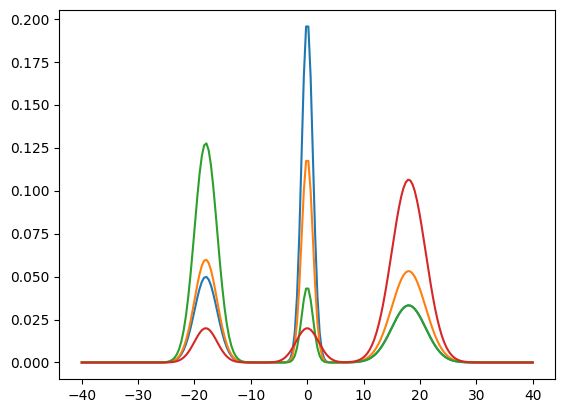

In [ ]:
#Just to check, make it better in the end
plt.plot(support, mixture1)
plt.plot(support, mixture2)
plt.plot(support, mixture3)
plt.plot(support, mixture4)

### Functions

In [ ]:
def global_stats(sample):
  samp_ext = []
  for i in range(len(sample)):
      samp_ext.extend(sample[i])
  return np.mean(samp_ext), np.var(samp_ext)

In [ ]:
def t_student_eval(x, df, mu, sigmaq):
    logfx = math.lgamma((df + 1)/2) - math.lgamma(df/2) - 1/2*np.log(math.pi*df*sigmaq) - ((df + 1)/2)*np.log(1 + ((x - mu)**2)/(df*sigmaq))
    return np.exp(logfx)

In [ ]:
def t_student_vector_eval(support, df, mu, sigmaq):
    probs = []
    for point in support:
        probs.append(t_student_eval(point, df, mu, sigmaq))
    return probs

In [ ]:
#Generating a random sample from the above mixture
def sampler(sample_sizes, weights):
    sample = []
    color_maps = []
    for size, weight in zip(sample_sizes, weights):
      group = []
      color_map = []
      un_val = np.random.uniform(0, 1, size)
      for i in range(size):
          if un_val[i] < weight[0]:
              group.append(np.random.normal(0, 1))
              color_map.append('orange')
          elif un_val[i] < (weight[0] + weight[1]):
              group.append(np.random.normal(-18, 2))
              color_map.append('blue')
          else:
              group.append(np.random.normal(18, 3))
              color_map.append('green')
      group = np.asarray(group)
      sample.append(group)
      color_maps.append(color_map)
    return sample, color_maps

In [ ]:
#ASSIGNMENT PROBABILITIES CALCULATOR FUNCTION
def assignment_probs(sample):
    element = sample[j][i]
    unnorm_probs = []
    l_j_ = np.sum(L[j, :])
    l__ = np.sum(L)

    #Compute probabilities for old local clusters in j-th group
    for h in range(l_j_):
        q = Q[j][h] #retrieve cardinality of h-th local cluster
        f = F[j][h] #retrieve global cluster associated to the h-th local cluster
        obs = []
        for m in range(J):
            obs.extend(sample[m][np.where(DD[m] == f)])
        cluster_data_sum = sum(obs)
        cl_card = len(obs) #cardinality of the set of selected observations
        a_n = a + cl_card/2
        v = 2*a_n
        mu_n = (cluster_data_sum + beta*mu_0)/(cl_card + beta)
        b_n = b + .5*((np.sum((obs - np.mean(obs))**2)) + ((beta*cl_card)*(np.mean(obs) - mu_0)**2)/(beta + cl_card))
        old_cl_var = (2*b_n*(1 + cl_card + beta))/(v*(cl_card + beta))
        prob = (q + 1)*(I_j + gamma - l_j_ - 1)/((I_j - 1)*(I_j + gamma - 1))*t_student_eval(element, v, mu_n, old_cl_var)
        unnorm_probs.append(prob)

    #Compute probabilities for new local cluster but old global ones
    for h in range(D):
        l__d = np.sum(L[:, h])
        obs = []
        for m in range(J):
            obs.extend(sample[m][np.where(DD[m] == h)])
        cluster_data_sum = sum(obs)
        cl_card = len(obs)
        a_n = a + cl_card/2
        v = 2*a_n
        mu_n = (cluster_data_sum + beta*mu_0)/(cl_card + beta)
        b_n = b + .5*((np.sum((obs - np.mean(obs))**2)) + ((beta*cl_card)*(np.mean(obs) - mu_0)**2)/(beta + cl_card))
        old_cl_var = (2*b_n*(1 + cl_card + beta))/(v*(cl_card + beta))
        prob = (l_j_*(l_j_ - gamma))*((l__d + 1)*(l__ + gamma_0 - D))/((I_j - 1)*(I_j + gamma - 1)*l__*(l__ + gamma_0))*t_student_eval(element, v, mu_n, old_cl_var)
        unnorm_probs.append(prob)

    #Compute probability for new local and global cluster
    v = 2*a
    new_cl_var = (2*b*(1 + beta))/(beta*v)
    prob = ((l_j_)*(l_j_ - gamma)*D*(D - gamma_0))/((I_j - 1)*((I_j + gamma - 1)*l__*(l__ + gamma_0)))*t_student_eval(element, v, mu_0, new_cl_var)
    unnorm_probs.append(prob)

    #Normalizing probabilities
    unnorm_probs = np.array(unnorm_probs)
    norm_probs = unnorm_probs/sum(unnorm_probs)

    #These are needed for getting the delimiting indexes of the different cases
    return norm_probs, l_j_ - 1, l_j_ + D - 1

In [ ]:
def cluster_assign(probs):
    U = np.random.uniform(0, 1)
    cum = probs[0]
    i = 0
    while U > cum:
        i += 1
        cum += probs[i]
    return i

In [ ]:
#This function converts the above format into partitions represented by list of lists
def converter(matrix):
    out = {j : [] for j in range(J)}
    for j in range(J):
        if -2 in np.unique(matrix[j]):
            matr = np.delete(matrix[j], np.where(matrix[j] == -2))
        else:
            matr = matrix[j]
        clusters_ids = np.unique(matr)
        for i_d in clusters_ids:
            out[j].append(np.where(matr == i_d)[0].tolist())
    return out

In [ ]:
#Predictive distribution
def posterior_predictive_pdf(support, j, sample):

    mixture = []
    for t in range(T):
        weights = []
        densities = []
        C = C_iters[t]
        DD = DD_iters[t]
        L = L_iters[t]
        Q = Q_iters[t]
        F = F_iters[t]
        l_j_ = np.sum(L[j, :])
        I_j = sample_sizes[j]
        l__ = np.sum(L)

        #Old-old case
        for h in range(l_j_):
            q = Q[j][h]
            f = F[j][h]
            #Weights
            weights.append(((q + 1)*(I_j - l_j_ + gamma))/(I_j*(I_j + gamma)))
            #Densities
            obs = []
            for m in range(J):
                obs.extend(sample[m][np.where(DD[m] == f)])
            cluster_data_sum = sum(obs)
            cl_card = len(obs)
            a_n = a + cl_card/2
            v = 2*a_n
            mu_n = (cluster_data_sum + beta*mu_0)/(cl_card + beta)
            b_n = b + .5*((np.sum((obs - np.mean(obs))**2)) + ((beta*cl_card)*(np.mean(obs) - mu_0)**2)/(beta + cl_card))
            old_cl_var = (2*b_n*(1 + cl_card + beta))/(v*(cl_card + beta))
            densities.append(t_student_vector_eval(support, v, mu_n, old_cl_var))

        #New-old case
        #Determine D
        if -2 in np.unique(DD):
            D = len(np.unique(DD)) - 1
        else:
            D = len(np.unique(DD))

        for d in range(D):
            #Weights
            l__d = np.sum(L[:, d])
            weights.append((l_j_*(l_j_ - gamma)*(l__d + 1)*(l__ - D + gamma_0))/(I_j*(I_j + gamma)*l__*(l__ + gamma_0)))
            #Densities
            obs = []
            for m in range(J):
                obs.extend(sample[m][np.where(DD[m] == d)])
            cluster_data_sum = sum(obs)
            cl_card = len(obs)
            a_n = a + cl_card/2
            v = 2*a_n
            mu_n = (cluster_data_sum + beta*mu_0)/(cl_card + beta)
            b_n = b + .5*((np.sum((obs - np.mean(obs))**2)) + ((beta*cl_card)*(np.mean(obs) - mu_0)**2)/(beta + cl_card))
            old_cl_var = (2*b_n*(1 + cl_card + beta))/(v*(cl_card + beta))
            densities.append(t_student_vector_eval(support, v, mu_n, old_cl_var))

        #New-new case
        #Weight
        weights.append((l_j_*(l_j_ - gamma)*D*(D - gamma_0))/(I_j*(I_j + gamma)*l__*(l__ + gamma_0)))

        #Density
        v = 2*a
        new_cl_var = (2*b*(1 + beta))/(beta*v)
        densities.append(t_student_vector_eval(support, v, mu_0, new_cl_var))

        #Normalizing weights: they sum up to one already but not always due to approx.
        weights = np.array(weights)
        weights_norm = weights/np.sum(weights)

        mixture.append(np.dot(weights_norm, densities))

    #Averaging over T Gibbs sampler iterations
    final_mixture = np.sum(mixture, axis = 0)/T
    return final_mixture

### Gibbs Sampler

In [ ]:
#Sampling: here it is possible to change the sample size of each group of data
weights = [weights1, weights2, weights3, weights4]
sample_sizes = [40, 60, 80, 150]
sample, color_maps_true = sampler(sample_sizes, weights)

In the following cell, there are some parameters to set up; these are:
* $T$, which is the number of scans to be performed by the sampler;
* $\gamma_0$, that is the parameter of the "global" Gnedin process. It must be that $0<\gamma_0<1$;
* $\gamma$, that is the parameter of the Gnedin processes referred to groups. It must be that $0<\gamma<1$;
* $\mu_0$, the mean of the normal part of the prior;
* $\beta$, scales the inverse variance ($\tau$) of the normal part of the prior;
* $a, b$, the parameters of the Gamma distribution of the prior.

In [ ]:
#We compute sample stats and use them for hyperparameters choice
global_mean, global_var = global_stats(sample)

#Parameters initialization
gamma = .5
gamma_0 = .5
J = len(sample) #number of groups
T = 2500
a = 3
b = global_var
mu_0 = global_mean
beta = 1.5
D = 1 #number of global clusters
C = np.zeros(shape = (J, max(sample_sizes)), dtype = 'int32') #(j,i)-th entry is the local cluster of the i-th obs, of the j-th group
for j in range(J):
    I_j = len(sample[j])
    C[j][I_j:] = -2
DD = np.zeros(shape = (J, max(sample_sizes)), dtype = 'int32') #(j,i)-th entry is the global cluster of the i-th obs, of the j-th group
for j in range(J):
    I_j = len(sample[j])
    DD[j][I_j:] = -2
Q = {j : np.array([sample_sizes[j]]) for j in range(J)} #local clusters cardinalities
F = {j : np.array([0]) for j in range(J)} #link between local clusters and their global assigned cluster
L = np.ones(shape = (J, D), dtype = 'int32') #(j,d)-th entry is the number of clusters in j-th group which are then grouped globally under d

#Stuff needed later for diagnostic and density estimation
local_cluster_counter = [[] for j in range(J)]
global_cluster_counter = []
C_iters = []
DD_iters = []
Q_iters = []
L_iters = []
F_iters = []

Run the following cell to start the algorithm

In [ ]:
#Gibbs sampler
for t in tqdm(range(T)):
    for j in range(J):
        I_j = len(sample[j])
        for i in range(I_j):

            #Remove (j,i)-th observation
            d = DD[j, i] #retrieve global cluster assignment of (j,i)-th observation
            c = C[j, i] #retrieve local cluster assignment of (j,i)-th observation
            Q[j][c] -= 1 #removing (j,i)-th obs. means reducing the cardinality by one
            C[j, i] = -1 #the removed obs. is temporarily assigned index -1 which means it is removed
            DD[j, i] = -1 #the removed obs. is temporarily assigned index -1 which means it is removed

            #If a local cluster becomes empty, we need to update the clusters counts and the indexes
            if Q[j][c] == 0:
                L[j, d] -= 1
                Q[j] = np.delete(Q[j], c) #remove the cluster of card. 0 from the array
                F[j] = np.delete(F[j], c) #remove the global cluster assignment of the now empty local cluster
                C[j][C[j] > c] -= 1 #reducing indexes by one

            #If a global cluster becomes empty, we need to update the clusters counts and the indexes
            r = 0
            while r < L.shape[1]:
                if sum(L[:, r]) == 0:
                    L = np.delete(L, r, 1)
                    D -= 1
                    #It can happen that d is equal to the dish we eliminated, so we need in that case to scale it by one
                    if d == D:
                        d -= 1
                    #Reducing indexes by one both in DD and F
                    DD[DD > r] -= 1
                    for k in range(J):
                        F[k][F[k] > r] -= 1
                    r -= 1 #need to adjust r since L.shape[1] reduces by one
                r += 1

            #Compute the probabilities of assignment
            probs, old_old_delim, new_old_delim = assignment_probs(sample)

            #Sample one of these probabilities and assign the (j,i)-th observation accordingly
            assignment_index = cluster_assign(probs)

            if assignment_index <= old_old_delim:
                C[j, i] = assignment_index
                DD[j, i] = F[j][C[j, i]]
                Q[j][C[j, i]] += 1
            elif assignment_index <= new_old_delim:
                C[j, i] = np.sum(L[j, :]) # = l_j_. we don't need the + 1 since the first cluster has index 0
                d = assignment_index - np.sum(L[j, :]) #retrieve d
                DD[j, i] = d
                Q[j] = np.append(Q[j], 1)
                F[j] = np.append(F[j], d)
                L[j, d] += 1

            else:
                C[j, i] = np.sum(L[j, :]) # = l_j_. we don't need the + 1 since the first cluster has index 0
                DD[j, i] = D #we don't need the + 1 since the first cluster has index 0
                Q[j] = np.append(Q[j], 1)
                F[j] = np.append(F[j], D)
                L = np.hstack((L, np.array([[0]]*J))) #need to update L
                L[j, D] += 1
                D += 1 #however we then need to augment the total number of clusters

    #For diagnostic and density estimation
    C_iters.append(copy.deepcopy(C))
    DD_iters.append(copy.deepcopy(DD))
    Q_iters.append(copy.deepcopy(Q))
    L_iters.append(copy.deepcopy(L))
    F_iters.append(copy.deepcopy(F))
    for j in range(J):
        local_cluster_counter[j].append(len(Q[j]))
    global_cluster_counter.append(D)

100%|██████████| 2500/2500 [18:12<00:00,  2.29it/s]


### Diagnostic Plots

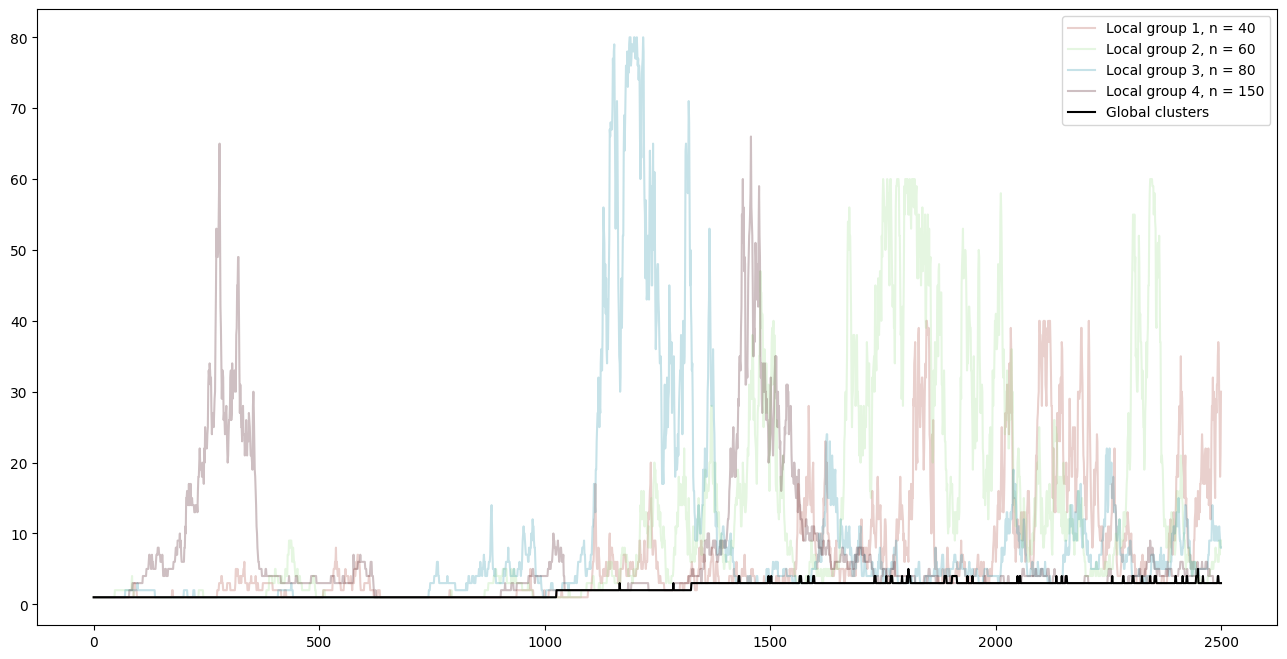

In [ ]:
#Progression of the number of clusters across iterations, both local and global
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16, 8))
for j in range(J):
    color = '#{:06x}'.format(random.randint(0, 0xFFFFFF))
    axes.plot(local_cluster_counter[j], color = color, label = j, alpha = .25)
axes.plot(global_cluster_counter, color = 'black', label = J)
axes.legend([f'Local group {j + 1}, n = {sample_sizes[j]}' if j + 1 <= J else 'Global clusters' for j in range(J + 1)])
#fig.suptitle('Evolution of clusters cardinality among local groups and globally', size = 15)
fig.savefig('Clusters_evolution.pdf')

### Density Estimation

Here we use the information obtained through the Gibbs iterations to estimate the real density.

In [ ]:
#Discard burn-in
burn_in = 500
C_iters = C_iters[burn_in:]
DD_iters = DD_iters[burn_in:]
Q_iters = Q_iters[burn_in:]
L_iters = L_iters[burn_in:]
F_iters = F_iters[burn_in:]
T = T - burn_in

Text(0.5, 0.98, 'Density estimation for each group')

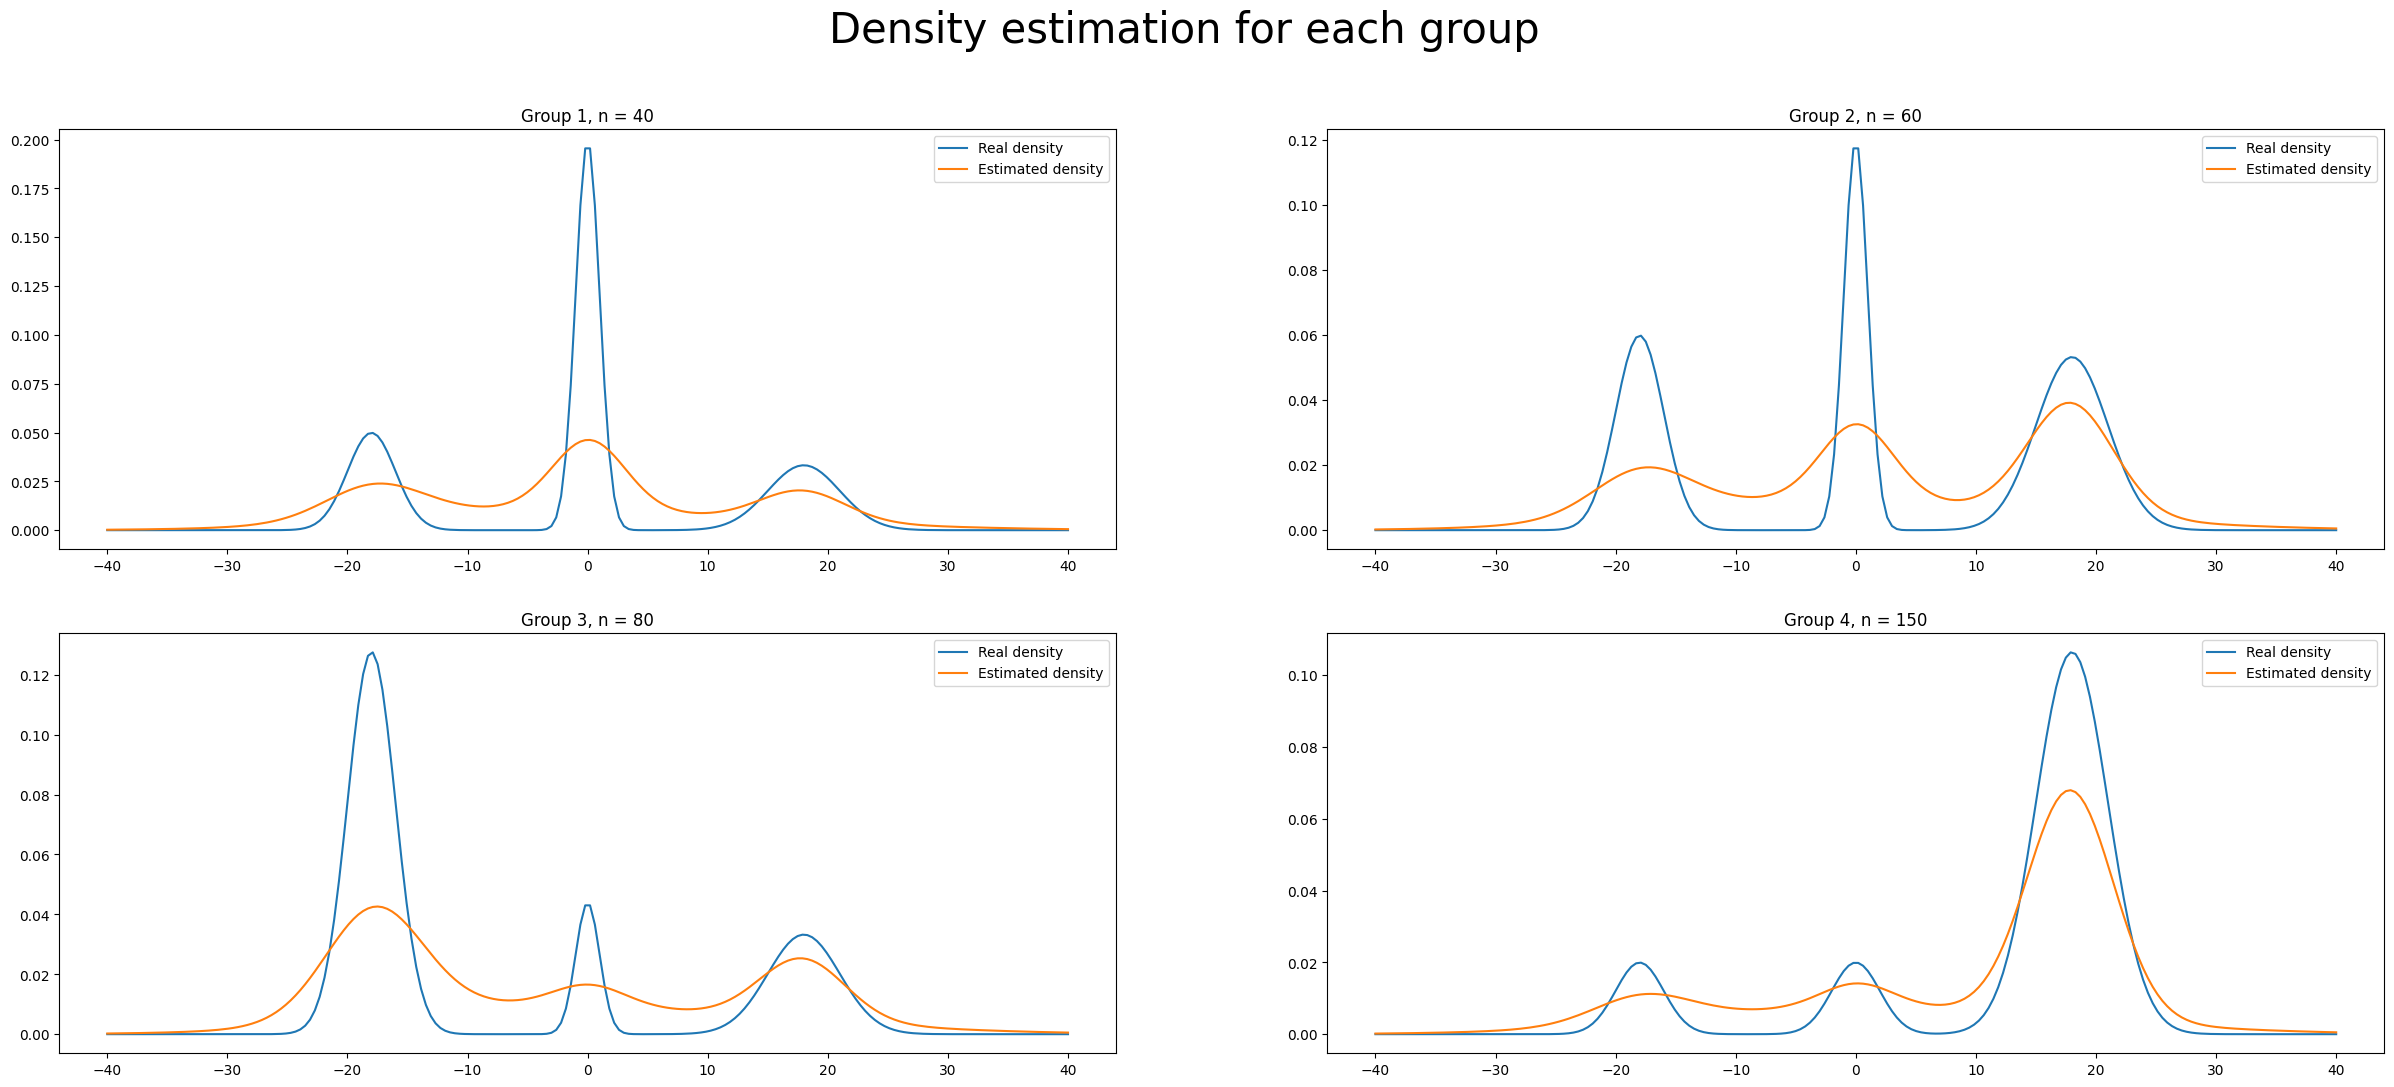

In [ ]:
density_estim = {j : posterior_predictive_pdf(support, j, sample) for j in range(J)}
mixtures = [mixture1, mixture2, mixture3, mixture4]
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (30, 12))
axes = axes.flatten() #to flatten it, since it is a 2x2 matrix
for j in range(J):
    axes[j].plot(support, mixtures[j])
    axes[j].plot(support, density_estim[j])
    axes[j].legend(['Real density', 'Estimated density'])
    axes[j].set_title(f'Group {j + 1}, n = {sample_sizes[j]}')
fig.suptitle('Density estimation for each group', size = 30)

### Salso for local clusters (tables)

In [ ]:
#We do this for the dishes, for each group. First of all we need to reorganise the DD information for each group, across Gibbs iterations
C_iters_per_group = {j : 0 for j in range(J)}
for j in range(J):
    mat = []
    for t in range(T):
        mat.append(C_iters[t][j][C_iters[t][j] != -2])
    C_iters_per_group[j] = np.array(mat)

In [ ]:
#Then we can compute the optimal partitions and posterior similarity matrices for each group
results = []
psm_s = []
orders = [] #to reorder psms
for j in range(J):
    #Activate conversion
    numpy2ri.activate()
    #Send to R
    r_mat = robjects.r.matrix(C_iters_per_group[j], nrow = C_iters_per_group[j].shape[0], ncol = C_iters_per_group[j].shape[1])
    #Run SALSO
    opt_part = np.array(list(salso.salso(r_mat)))
    results.append(opt_part)
    #Computing posterior similarity matrices
    psm_s.append(salso.psm(r_mat))
    orders.append(np.argsort(opt_part))

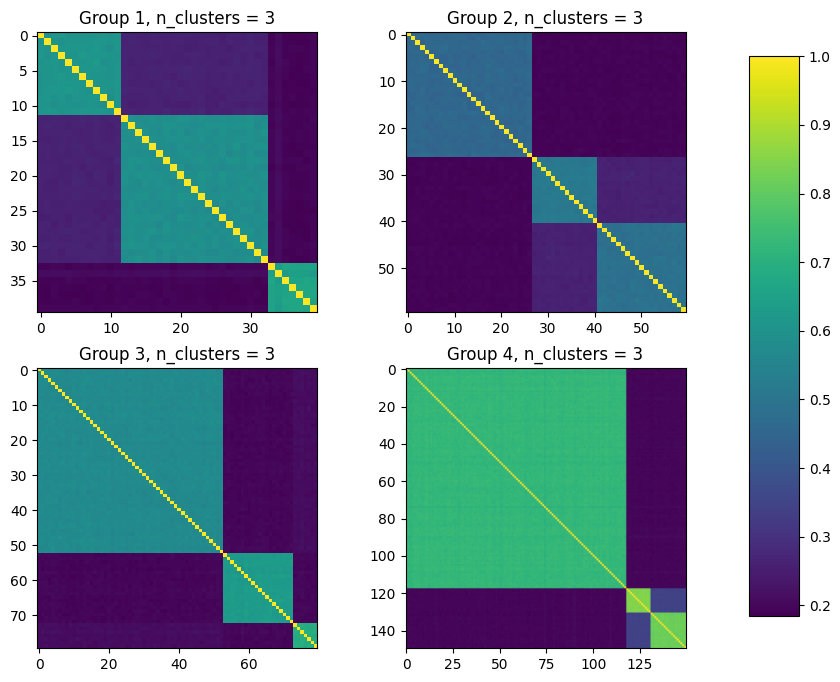

In [ ]:
#Plotting the posterior similarity matrices
fig, axes = plt.subplots(2, 2, figsize = (10, 8))
axes = axes.flatten()
for j in range(J):
  plot = axes[j].imshow(psm_s[j][orders[j]][:, orders[j]], cmap = 'viridis')
  axes[j].set_title(f'Group {j + 1}, n_clusters = {np.unique(results[j]).size}')

#Add unique colorbar
fig.subplots_adjust(right = 0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(plot, cax = cbar_ax)

#fig.suptitle('Posterior Similarity Matrices for tables', size = 15)
fig.savefig('PSM_tables.pdf')

### Salso for global clusters (dishes)

In [ ]:
#We need to combine each iteration in DD_iters to a single one-dimensional array and remove the -2's
DD_pooled_iters = []
for t in range(T):
  DD_pooled_iters.append(DD_iters[t].flatten()[DD_iters[t].flatten() != -2])
DD_pooled_iters = np.array(DD_pooled_iters)

In [ ]:
#Now we can run Salso to compute the optimal partition and the posterior similarity matrix
#Activate conversion
numpy2ri.activate()
#Send to R
r_mat = robjects.r.matrix(DD_pooled_iters, nrow = DD_pooled_iters.shape[0], ncol = DD_pooled_iters.shape[1])
#Run SALSO
opt_part_global = np.array(list(salso.salso(r_mat)))
#Computing posterior similarity matrices
psm_s_global = salso.psm(r_mat)
orders_global = np.argsort(opt_part_global)

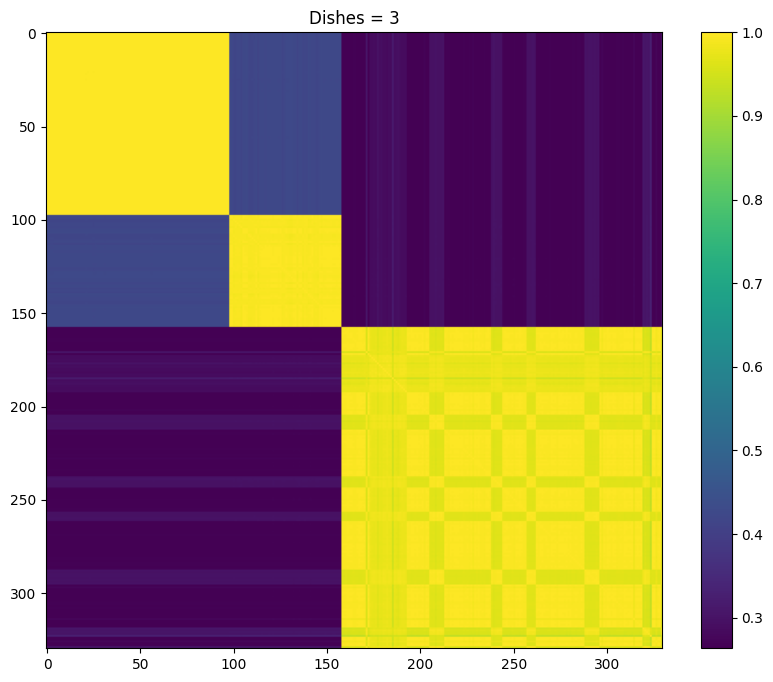

In [ ]:
#Now we can finally plot the psm ordered according to the optimal partition
fig, axes = plt.subplots(1, 1, figsize = (10, 8))
plot = axes.imshow(psm_s_global[orders_global][:, orders_global])
plt.colorbar(plot)
axes.set_title(f'Dishes = {len(np.unique(opt_part_global))}')
fig.savefig('PSM_dishes.pdf')

### Other plots

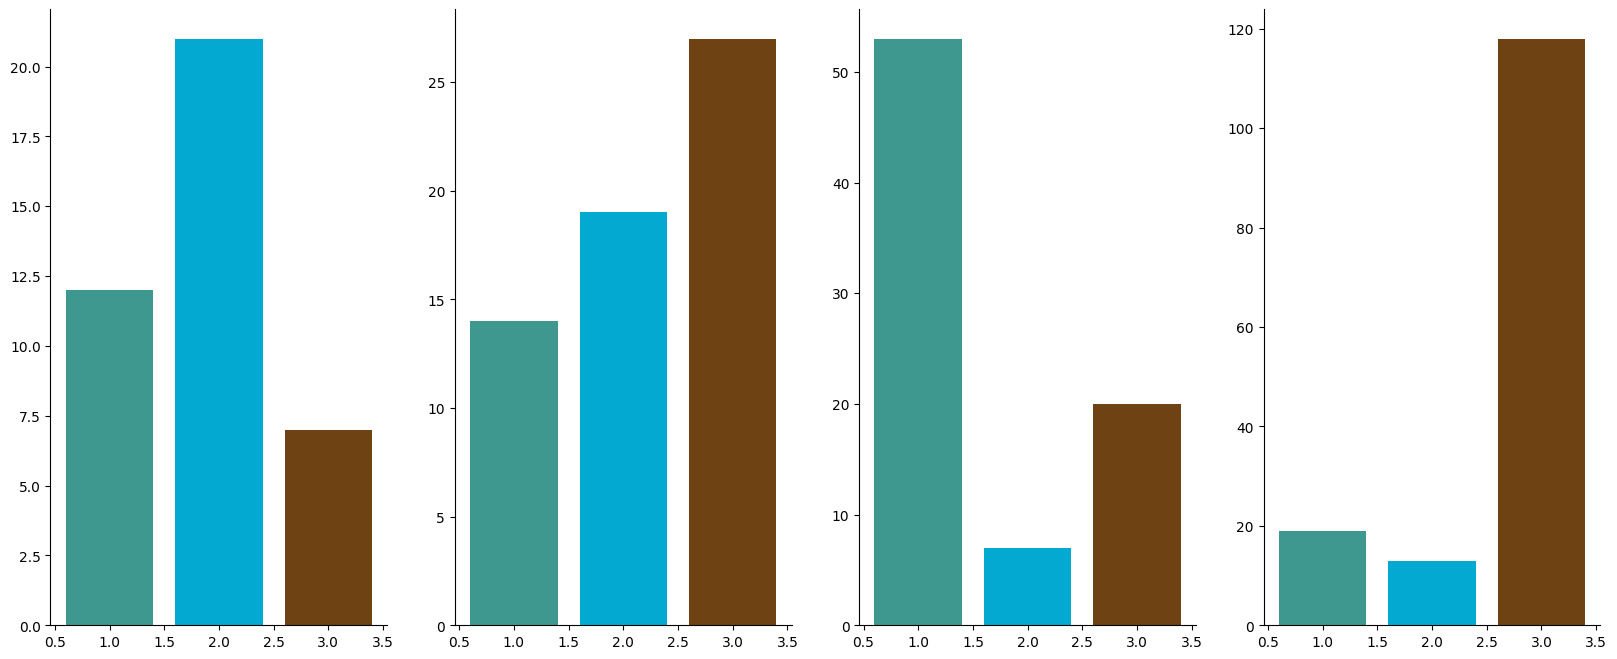

In [ ]:
#We extract dishes assignment for each group according to the optimal partition
indexing = [0]
indexing.extend(sample_sizes)
indexing = np.cumsum(indexing)
dish_assignment = []
for j in range(J):
  dish_assignment.append(opt_part_global[indexing[j]:indexing[j+1]])

#Now we plot
fig, axes = plt.subplots(1, J, figsize = (20, 8))
colors = ['#{:06x}'.format(random.randint(0, 0xFFFFFF)) for i in range(np.unique(opt_part_global).size)]
'''for j in range(J):
  cl, counts = np.unique(dish_assignment[j], return_counts = True)
  axes[j].bar(cl, counts, color = colors)
  axes[j].spines['top'].set_visible(False)
  axes[j].spines['right'].set_visible(False)'''

#Run to check if it works
x = [i + 1 for i in range(np.unique(opt_part_global).size)]
cls = []
for j in range(J):
  height = [0 for i in range(np.unique(opt_part_global).size)]
  cl, counts = np.unique(dish_assignment[j], return_counts = True)
  cls.append(cl) #needed for the plot below to get the right colors for each histogram piece
  for i in range(len(cl)):
    height[cl[i] - 1] = counts[i]
  axes[j].bar(x, height, color = colors)
  axes[j].spines['top'].set_visible(False)
  axes[j].spines['right'].set_visible(False)

#fig.suptitle('Number of dishes and their cardinalities for each group, according to the optimal partition', size = 15)
fig.savefig('Assigned_dishes_by_groups.pdf')

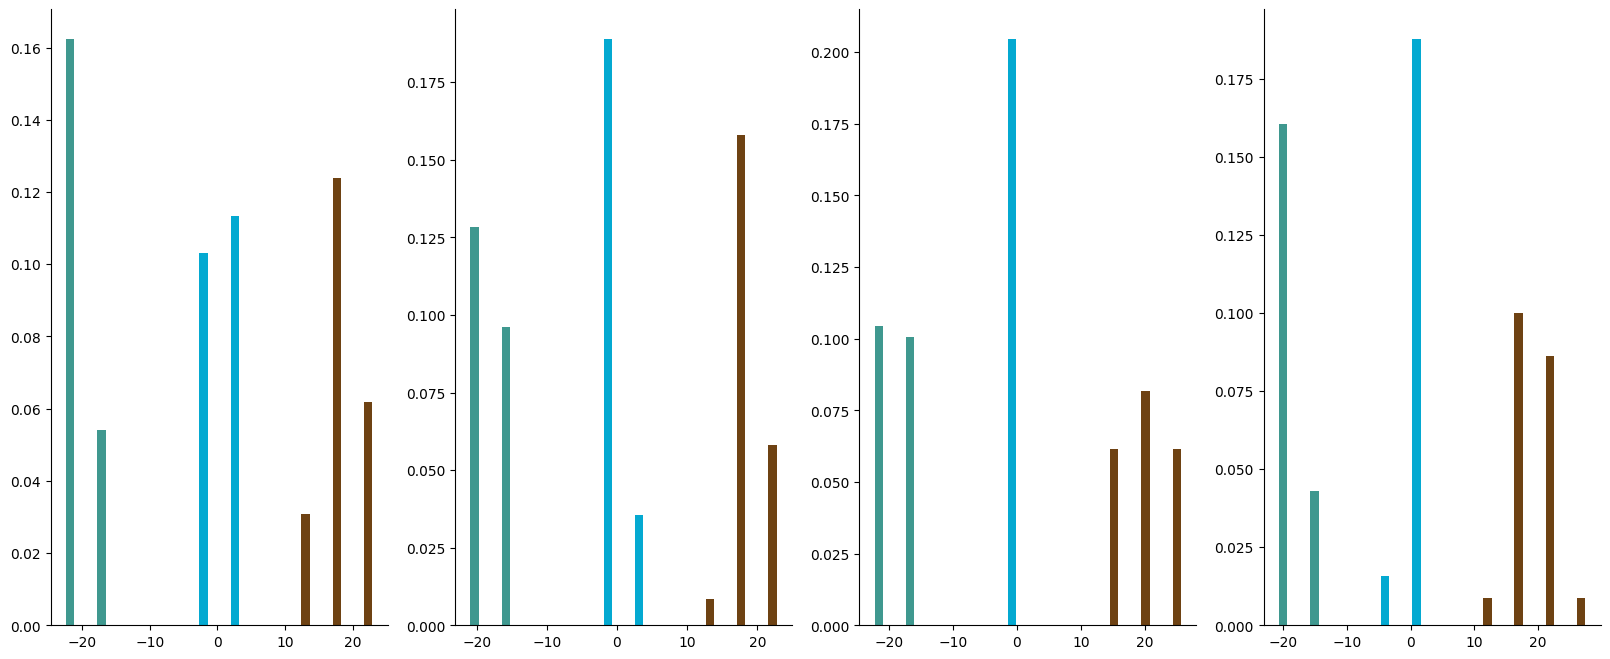

In [ ]:
#Similarly to the above plot, we now colour the histogram of the data samples according to assigned (optimal) dishes, for each group
#We now convert the optimal partition in another format, which is easier to deal with for plotting histograms
part_sample = converter(dish_assignment)
#Now we plot
fig, axes = plt.subplots(1, J, figsize = (20, 8))
for j in range(J):
  sub_samp = []
  sub_col = []
  for i in range(len(part_sample[j])):
    sub_samp.append(sample[j][part_sample[j][i]])
    sub_col.append(colors[cls[j][i] - 1])
  axes[j].hist(sub_samp, color = sub_col, density = True)
  axes[j].spines['top'].set_visible(False)
  axes[j].spines['right'].set_visible(False)
#fig.suptitle('Histogram of groups samples data, colored according to the optimal dishes partition', size = 15)
fig.savefig('Groups_hist_coloredby_dishes.pdf')

### Density Estimation + Rugs according to optimal partition of dishes + real data

In [ ]:
#Creating a color mask and an importance array
col_mask = copy.deepcopy(dish_assignment)
importance = copy.deepcopy(dish_assignment)
for j in range(J):
  for i in range(np.unique(opt_part_global).size):
    #Updating color mask
    col_mask[j] = np.array(col_mask[j], dtype = 'str') #we need to convert each array in the list in strings otherwise the next line won't work
    col_mask[j][col_mask[j] == f'{i + 1}'] = colors[i] #we now start from i + 1, since the cluster indices start from 1
    #Updating importance array
    importance[j][importance[j] == i + 1] = len(importance[j][importance[j] == i + 1]) #importance value is given by the number of observations in each group assigned to dish i

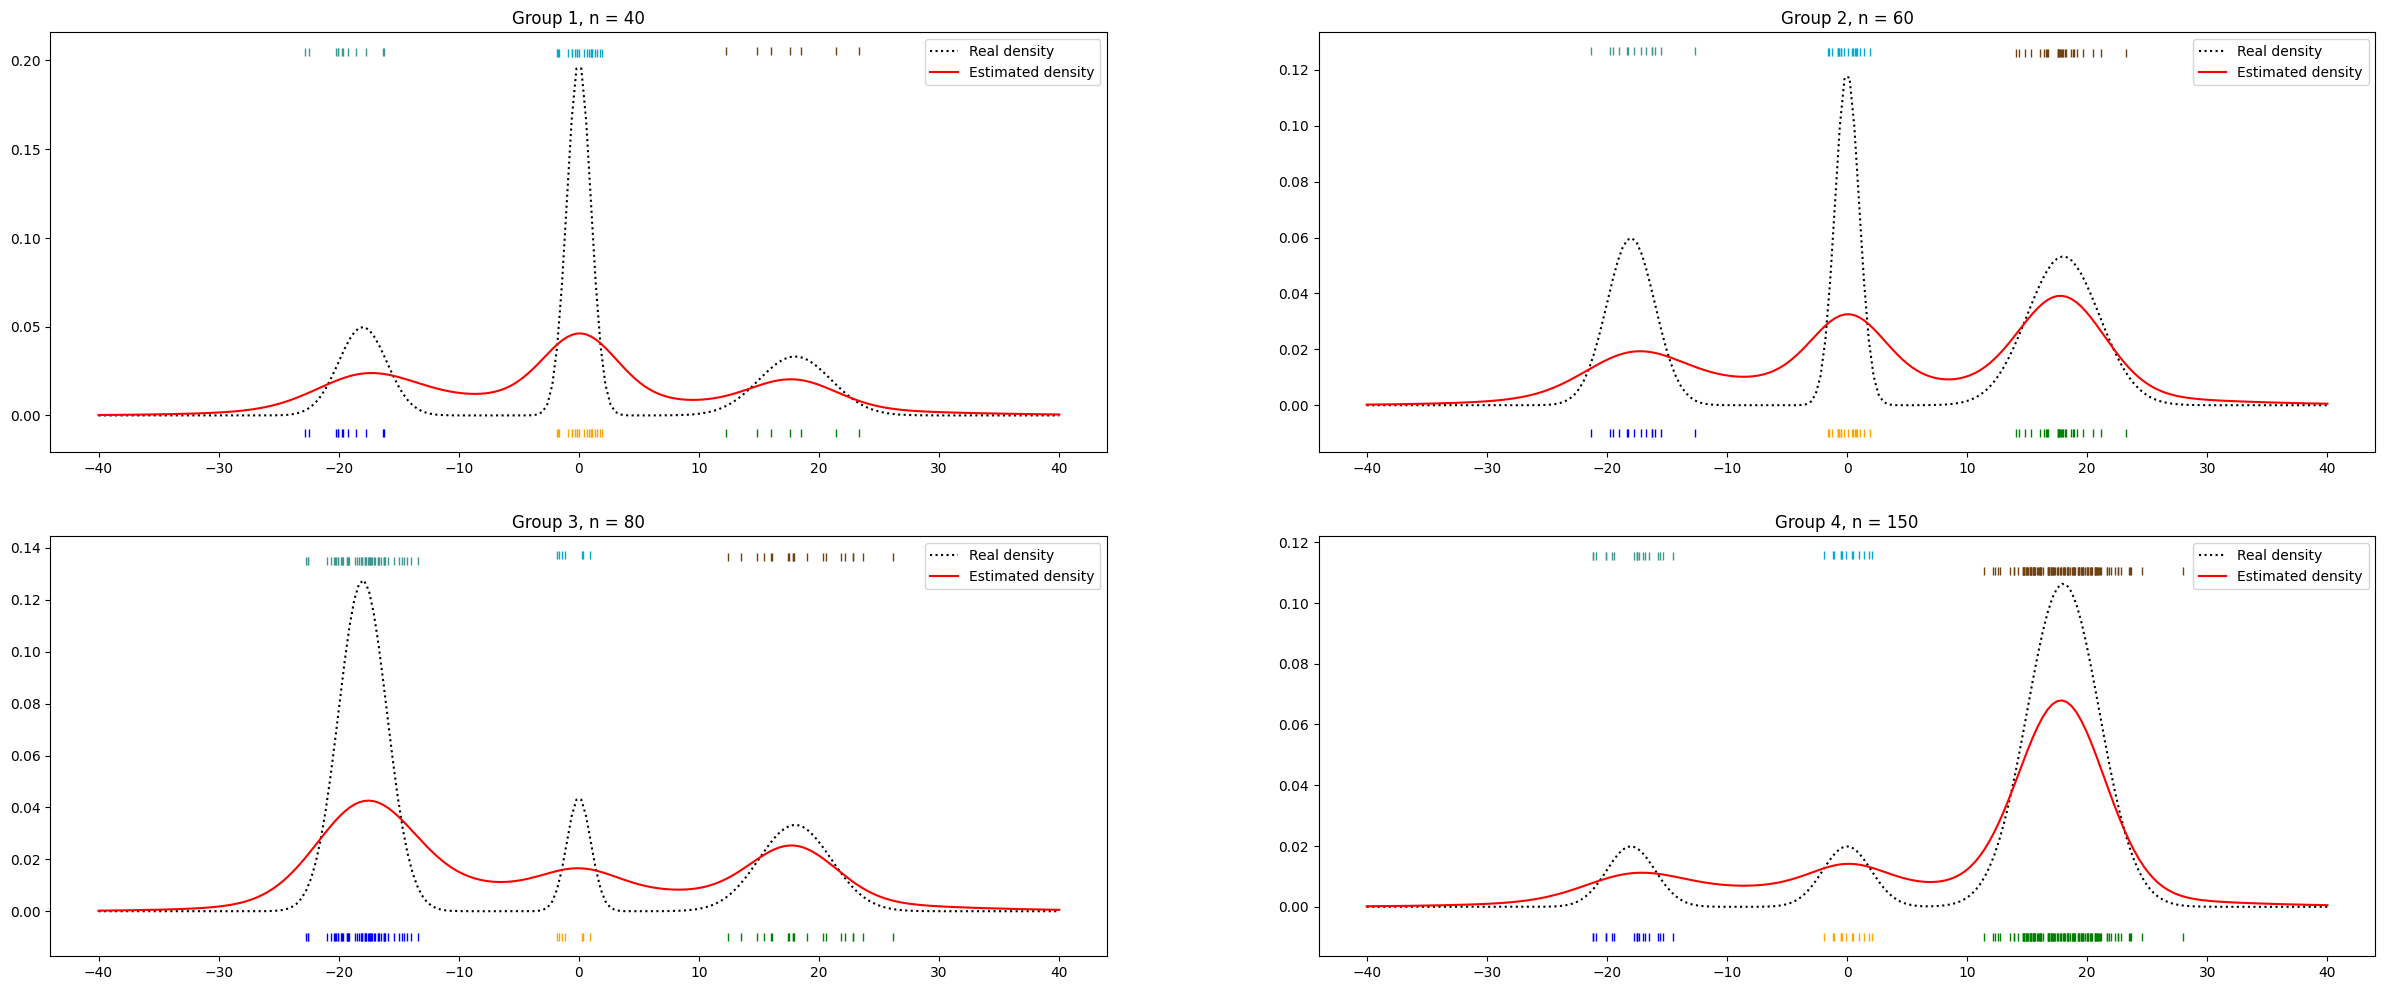

In [ ]:
#Now we plot
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (30, 12))
axes = axes.flatten() #to flatten it, since it is a 2x2 matrix
for j in range(J):
    maxx = max(max(mixtures[j]), max(density_estim[j]))
    axes[j].plot(support, mixtures[j], color = 'k', linestyle = 'dotted')
    axes[j].plot(support, density_estim[j], color = 'r')
    for i in range(sample_sizes[j]):
      axes[j].plot(sample[j][i], -.01, '|', color = color_maps_true[j][i])
      axes[j].plot(sample[j][i], maxx + .01 - (importance[j][i]*0.00005), '|', color = col_mask[j][i])
    axes[j].legend(['Real density', 'Estimated density'])
    axes[j].set_title(f'Group {j + 1}, n = {sample_sizes[j]}')
#fig.suptitle('Density estimation for each group', size = 30)
fig.savefig('Densiity_estim_vs_real_with_rugs.pdf')

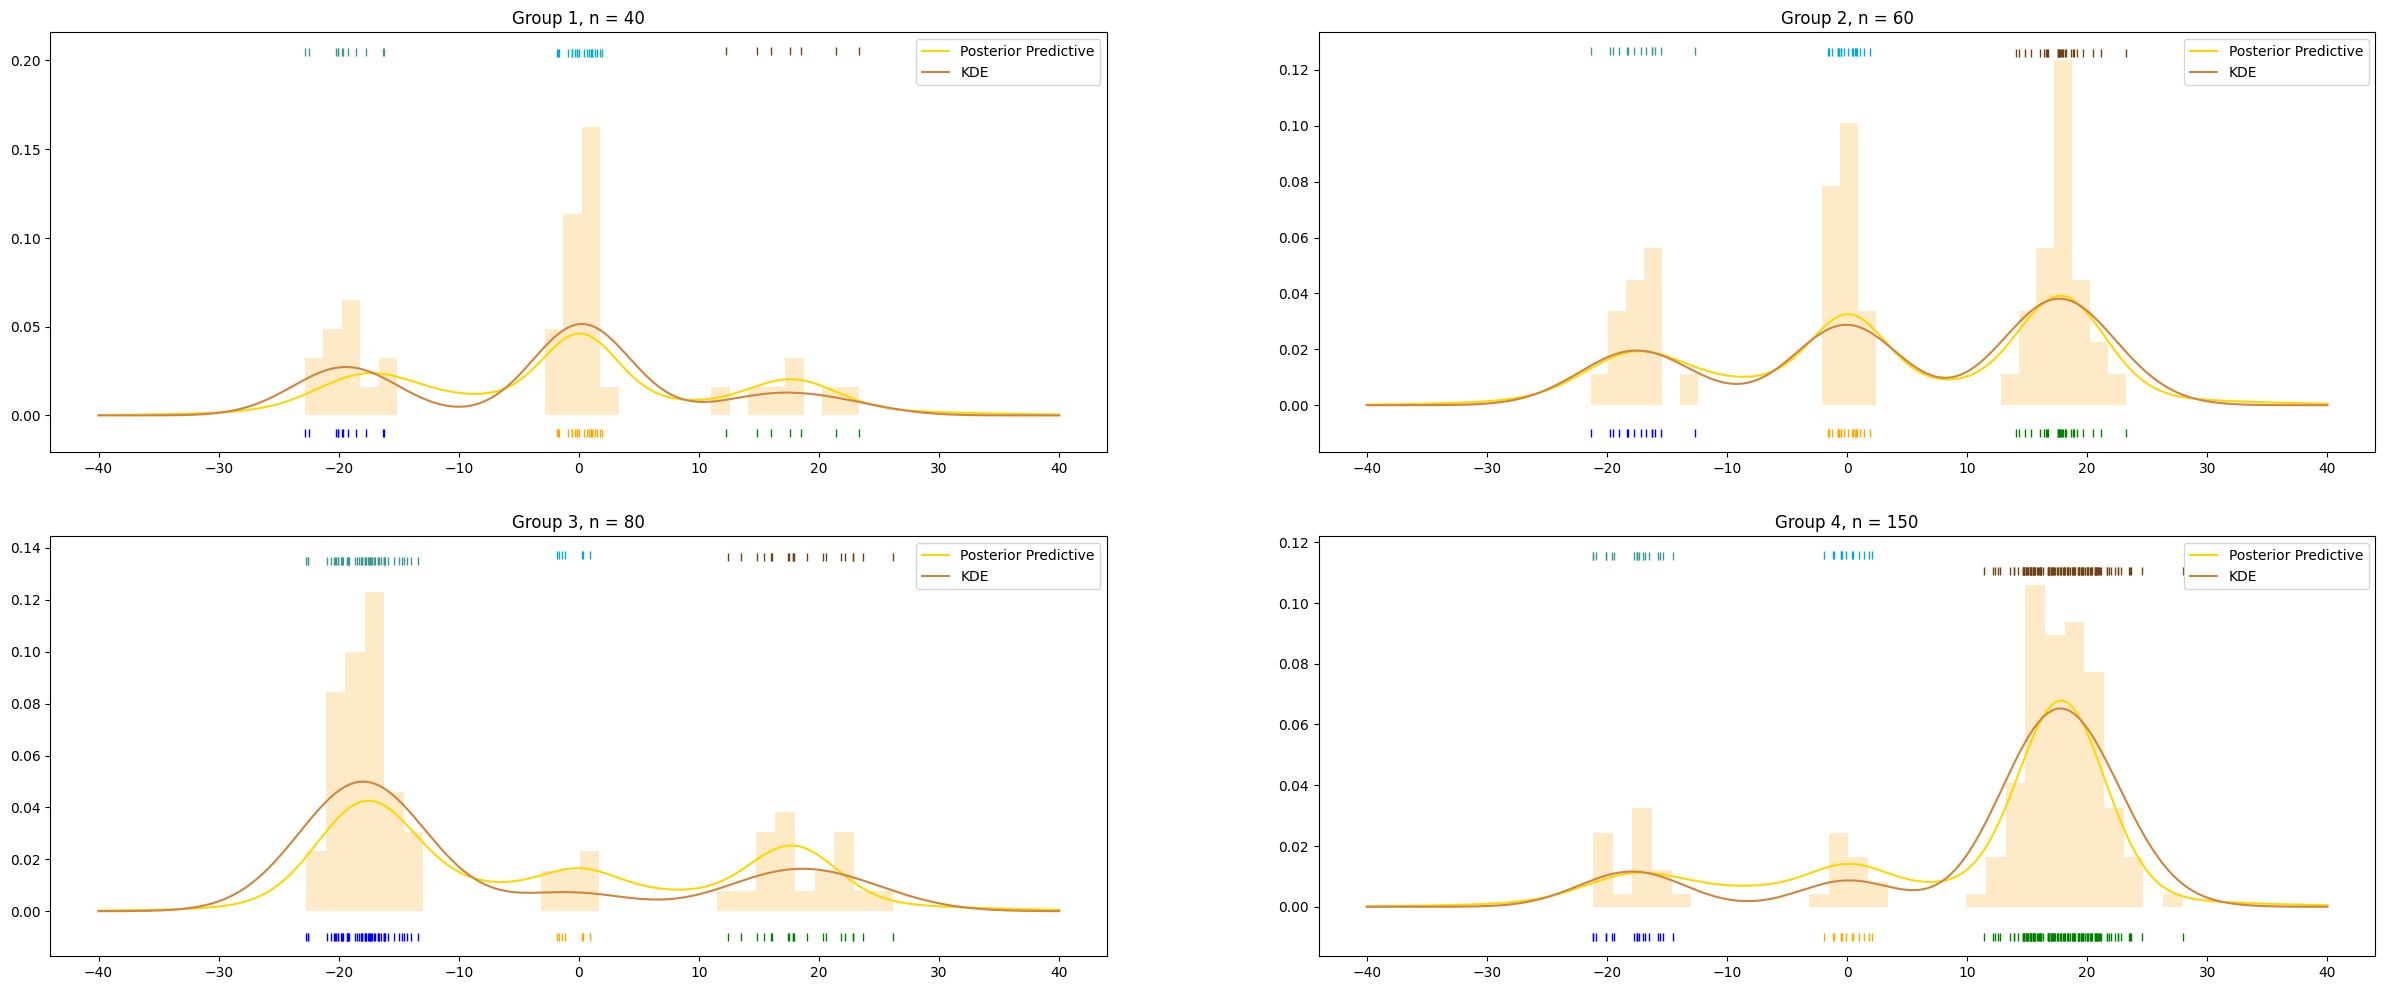

In [ ]:
#Bayesian Density Estimation vs. KDE
kde_evals = []
for j in range(J):
  kde = ss.gaussian_kde(sample[j], bw_method = .3)
  kde_evals.append(kde.pdf(support))

fig, axes = plt.subplots(2, 2, figsize = (30, 12))
axes = axes.flatten()
for j in range(J):
  maxx = max(max(mixtures[j]), max(density_estim[j]))
  axes[j].hist(sample[j], bins = 30, density = True, color = 'moccasin', alpha = .75)
  axes[j].plot(support, density_estim[j], color = 'gold')
  axes[j].plot(support, kde_evals[j], color = 'peru')
  for i in range(sample_sizes[j]):
      axes[j].plot(sample[j][i], -.01, '|', color = color_maps_true[j][i])
      axes[j].plot(sample[j][i], maxx + .01 - (importance[j][i]*0.00005), '|', color = col_mask[j][i])
  axes[j].legend(['Posterior Predictive', 'KDE'])
  axes[j].set_title(f'Group {j + 1}, n = {sample_sizes[j]}')
#fig.suptitle('Estimated density: Posterior predictive vs. KDE on data histograms', size = 21)
fig.savefig('Density_estim_vs_KDE_on_data_hist.pdf')

In [ ]:
#We want to find the observations belonging to each dish
#First of all we pool the observations together and we do the same with the dish assignments (we pool the groups into a single array)
obs_pool = []
dish_assignment_pool = []
for i in range(len(sample)):
  obs_pool.extend(sample[i])
  dish_assignment_pool.extend(dish_assignment[i])
obs_pool = np.array(obs_pool)

#Then we convert the format of dish_assignment_pool into the other one
part_sample_pool = []
for dish in np.unique(dish_assignment_pool):
  part_sample_pool.append(np.where(dish_assignment_pool == dish)[0].tolist())

for i in range(len(part_sample_pool)):
  print(f'Group {i + 1} -', 'Mean:', np.mean(obs_pool[part_sample_pool[i]]), 'StD:', np.std(obs_pool[part_sample_pool[i]]))

Group 1 - Mean: -18.08431439282585 StD: 2.155934902498945
Group 2 - Mean: 0.01378338667657807 StD: 1.1087286286415012
Group 3 - Mean: 17.992314122631527 StD: 2.917394892461527


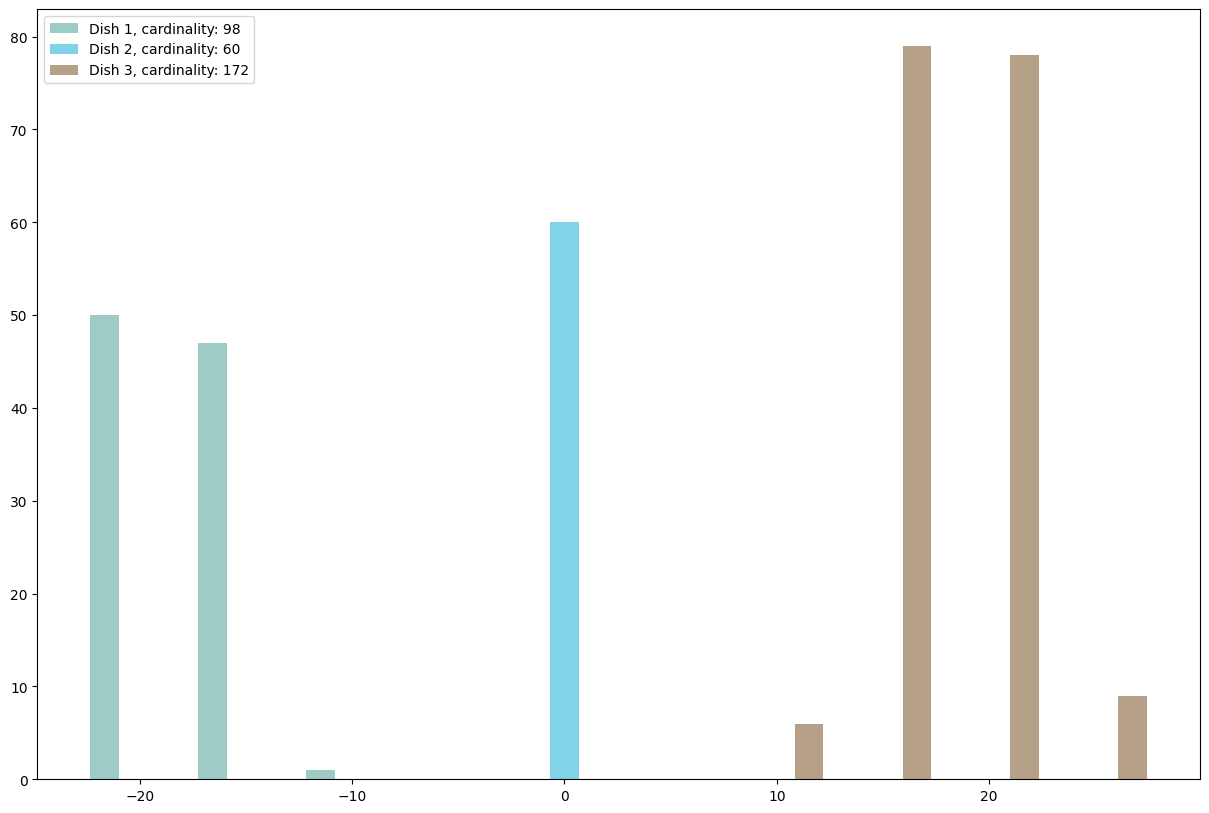

In [ ]:
#Now we plot the data histogram, subdivided by dishes
list_hist = []
for i in range(len(part_sample_pool)):
  list_hist.append(obs_pool[part_sample_pool[i]]) #since we start from 1 for dishes, not 0

fig, ax = plt.subplots(1, 1, figsize = (15, 10))
ax.hist(list_hist, color = colors, alpha = .5)
ax.legend([f'Dish {i + 1}, cardinality: {len(part_sample_pool[i])}' for i in range(len(part_sample_pool))])
fig.savefig('Hist_dishes.pdf')

# Real Data Example - Exoplanets, link: https://www.opendatabay.com/data/dataset/cacbbb52-7139-4f53-aa31-44496ac3b5ef?utm_source=chatgpt.com

In [ ]:
os.chdir(r'/content/drive/MyDrive/Colab Notebooks/Thesis/hierarchical/plots/Real data/exoplanets')

In [ ]:
#Importing the data set
dataset = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Thesis/hierarchical/data sets/NASA Exoplanets/PSCompPars_2023.09.06_16.02.03.csv')

This is a dataset containing exoplanets measurements. We are interested in the Stellar effective temperature (column st_teff). We will divide the data in this column according to the facility that discovered the exoplanet (column disc_facility).

In [ ]:
dataset['disc_facility'].unique() #these are the groups/polulations

array(['Xinglong Station', 'Thueringer Landessternwarte Tautenburg',
       'Okayama Astrophysical Observatory', 'W. M. Keck Observatory',
       'Multiple Observatories', 'Lick Observatory', 'Gemini Observatory',
       'Subaru Telescope', 'Paranal Observatory',
       'Cerro Tololo Inter-American Observatory',
       'Hubble Space Telescope', 'Kepler', 'Haute-Provence Observatory',
       'McDonald Observatory', 'Anglo-Australian Telescope',
       'Bohyunsan Optical Astronomical Observatory',
       'Transiting Exoplanet Survey Satellite (TESS)',
       'Roque de los Muchachos Observatory', 'K2',
       'Wide-field Infrared Survey Explorer (WISE) Sat',
       'La Silla Observatory', 'Calar Alto Observatory',
       'NASA Infrared Telescope Facility (IRTF)', 'CoRoT',
       'Multiple Facilities', 'Yunnan Astronomical Observatory',
       'Spitzer Space Telescope', 'MEarth Project',
       'Very Long Baseline Array', 'Acton Sky Portal Observatory',
       'Palomar Observatory',
      

In [ ]:
#Remove Nans from the column of interest
dataset = dataset[~dataset.st_teff.isnull()]

In [ ]:
#We extract the different groups observations
mapping = {facility : i for i, facility in enumerate(dataset.disc_facility.unique()) if len(list(dataset.st_teff[dataset.disc_facility == facility])) >= 20 and len(list(dataset.st_teff[dataset.disc_facility == facility])) <= 100} #map facility to a j
mapping = {facility : i for facility, i in zip(mapping.keys(), range(len(mapping)))} #correcting indexes (j's)
groups = {i : np.array(dataset.st_teff[dataset.disc_facility == facility]) for i, facility in enumerate(dataset['disc_facility'].unique()) if len(list(dataset.st_teff[dataset.disc_facility == facility])) >= 20 and len(list(dataset.st_teff[dataset.disc_facility == facility])) <= 100}
groups = {i : values for i, values in enumerate(groups.values())} #correcting indexes (j's)

0 35
1 35
2 40
3 64
4 29
5 36
6 26
7 30
8 35
9 67
10 73
11 29
12 32


(array([[0.00000000e+00, 5.24109015e-04, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [5.98981731e-05, 4.49236298e-04, 1.49745433e-05, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [1.17924528e-04, 2.88259958e-04, 5.24109015e-05, 3.93081761e-05,
         1.31027254e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 1.31027254e-05],
        [2.45676101e-05, 4.91352201e-04, 8.18920335e-06, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [1.80727246e-04, 3.43381768e-04, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [1.45585837e-05, 4.94991847e-04, 1.45585837e-05, 0.0

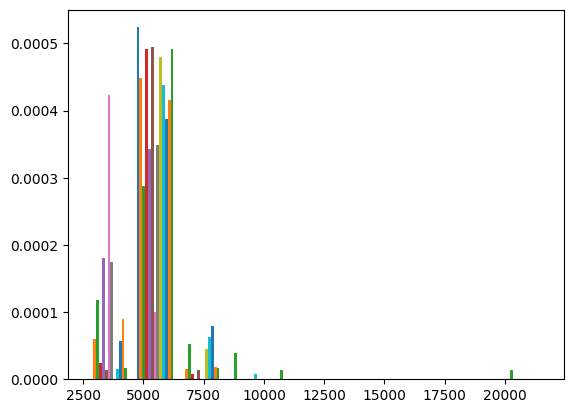

In [ ]:
#We check how many measurements we have for each group/polulation
sample_sizes = []
for key, group in groups.items():
  print(key, len(group))
  sample_sizes.append(len(group))

'''#We also check normality of the data
for group in groups.values():
  plt.hist(group, density = True)'''

plt.hist(groups.values(), density = True)

In [ ]:
#We compute sample stats and use them for hyperparameters choice
obs_pool = []
for obs in groups.values():
  obs_pool.extend(obs)
global_mean, global_var = np.mean(obs_pool), np.var(obs_pool)

#Parameters initialization
gamma = .5
gamma_0 = .25
J = len(groups) #number of groups
T = 5000
a = 3
b = global_var
mu_0 = global_mean
beta = 1.5
D = 1 #number of global clusters
C = np.zeros(shape = (J, max(sample_sizes)), dtype = 'int32') #(j,i)-th entry is the local cluster of the i-th obs, of the j-th group
for j in range(J):
    I_j = len(groups[j])
    C[j][I_j:] = -2
DD = np.zeros(shape = (J, max(sample_sizes)), dtype = 'int32') #(j,i)-th entry is the global cluster of the i-th obs, of the j-th group
for j in range(J):
    I_j = len(groups[j])
    DD[j][I_j:] = -2
Q = {j : np.array([sample_sizes[j]]) for j in range(J)} #local clusters cardinalities
F = {j : np.array([0]) for j in range(J)} #link between local clusters and their global assigned cluster
L = np.ones(shape = (J, D), dtype = 'int32') #(j,d)-th entry is the number of clusters in j-th group which are then grouped globally under d

#Stuff needed later for diagnostic and density estimation
local_cluster_counter = [[] for j in range(J)]
global_cluster_counter = []
C_iters = []
DD_iters = []
Q_iters = []
L_iters = []
F_iters = []

In [ ]:
#Gibbs sampler
for t in tqdm(range(T)):
    for j in range(J):
        I_j = len(groups[j])
        for i in range(I_j):

            #Remove (j,i)-th observation
            d = DD[j, i] #retrieve global cluster assignment of (j,i)-th observation
            c = C[j, i] #retrieve local cluster assignment of (j,i)-th observation
            Q[j][c] -= 1 #removing (j,i)-th obs. means reducing the cardinality by one
            C[j, i] = -1 #the removed obs. is temporarily assigned index -1 which means it is removed
            DD[j, i] = -1 #the removed obs. is temporarily assigned index -1 which means it is removed

            #If a local cluster becomes empty, we need to update the clusters counts and the indexes
            if Q[j][c] == 0:
                L[j, d] -= 1
                Q[j] = np.delete(Q[j], c) #remove the cluster of card. 0 from the array
                F[j] = np.delete(F[j], c) #remove the global cluster assignment of the now empty local cluster
                C[j][C[j] > c] -= 1 #reducing indexes by one

            #If a global cluster becomes empty, we need to update the clusters counts and the indexes
            r = 0
            while r < L.shape[1]:
                if sum(L[:, r]) == 0:
                    L = np.delete(L, r, 1)
                    D -= 1
                    #It can happen that d is equal to the dish we eliminated, so we need in that case to scale it by one
                    if d == D:
                        d -= 1
                    #Reducing indexes by one both in DD and F
                    DD[DD > r] -= 1
                    for k in range(J):
                        F[k][F[k] > r] -= 1
                    r -= 1 #need to adjust r since L.shape[1] reduces by one
                r += 1

            #Compute the probabilities of assignment
            probs, old_old_delim, new_old_delim = assignment_probs(groups)

            #Sample one of these probabilities and assign the (j,i)-th observation accordingly
            assignment_index = cluster_assign(probs)

            if assignment_index <= old_old_delim:
                C[j, i] = assignment_index
                DD[j, i] = F[j][C[j, i]]
                Q[j][C[j, i]] += 1
            elif assignment_index <= new_old_delim:
                C[j, i] = np.sum(L[j, :]) # = l_j_. we don't need the + 1 since the first cluster has index 0
                d = assignment_index - np.sum(L[j, :]) #retrieve d
                DD[j, i] = d
                Q[j] = np.append(Q[j], 1)
                F[j] = np.append(F[j], d)
                L[j, d] += 1

            else:
                C[j, i] = np.sum(L[j, :]) # = l_j_. we don't need the + 1 since the first cluster has index 0
                DD[j, i] = D #we don't need the + 1 since the first cluster has index 0
                Q[j] = np.append(Q[j], 1)
                F[j] = np.append(F[j], D)
                L = np.hstack((L, np.array([[0]]*J))) #need to update L
                L[j, D] += 1
                D += 1 #however we then need to augment the total number of clusters

    #For diagnostic and density estimation
    C_iters.append(copy.deepcopy(C))
    DD_iters.append(copy.deepcopy(DD))
    Q_iters.append(copy.deepcopy(Q))
    L_iters.append(copy.deepcopy(L))
    F_iters.append(copy.deepcopy(F))
    for j in range(J):
        local_cluster_counter[j].append(len(Q[j]))
    global_cluster_counter.append(D)

100%|██████████| 5000/5000 [2:05:46<00:00,  1.51s/it]


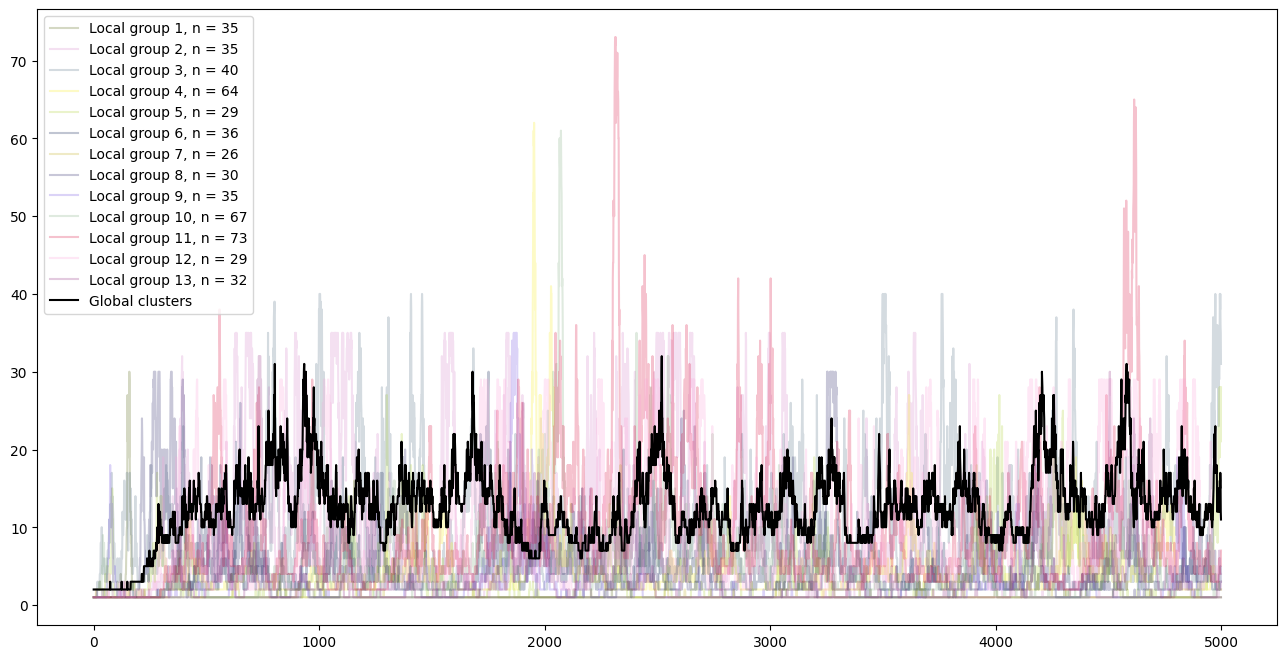

In [ ]:
#Progression of the number of clusters across iterations, both local and global
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16, 8))
for j in range(J):
    color = '#{:06x}'.format(random.randint(0, 0xFFFFFF))
    axes.plot(local_cluster_counter[j], color = color, label = j, alpha = .25)
axes.plot(global_cluster_counter, color = 'black', label = J)
axes.legend([f'Local group {j + 1}, n = {sample_sizes[j]}' if j + 1 <= J else 'Global clusters' for j in range(J + 1)], loc = 'upper left')
#fig.suptitle('Evolution of clusters cardinality among local groups and globally', size = 15)
fig.savefig('Cl_evol.pdf')

### Salso for tables and dishes

In [ ]:
#We do this for the dishes, for each group. First of all we need to reorganise the DD information for each group, across Gibbs iterations
C_iters_per_group = {j : 0 for j in range(J)}
for j in range(J):
    mat = []
    for t in range(T):
        mat.append(C_iters[t][j][C_iters[t][j] != -2])
    C_iters_per_group[j] = np.array(mat)

In [ ]:
#Then we can compute the optimal partitions and posterior similarity matrices for each group
results = []
psm_s = []
orders = [] #to reorder psms
for j in range(J):
    #Activate conversion
    numpy2ri.activate()
    #Send to R
    r_mat = robjects.r.matrix(C_iters_per_group[j], nrow = C_iters_per_group[j].shape[0], ncol = C_iters_per_group[j].shape[1])
    #Run SALSO
    opt_part = np.array(list(salso.salso(r_mat)))
    results.append(opt_part)
    #Computing posterior similarity matrices
    psm_s.append(salso.psm(r_mat))
    orders.append(np.argsort(opt_part))

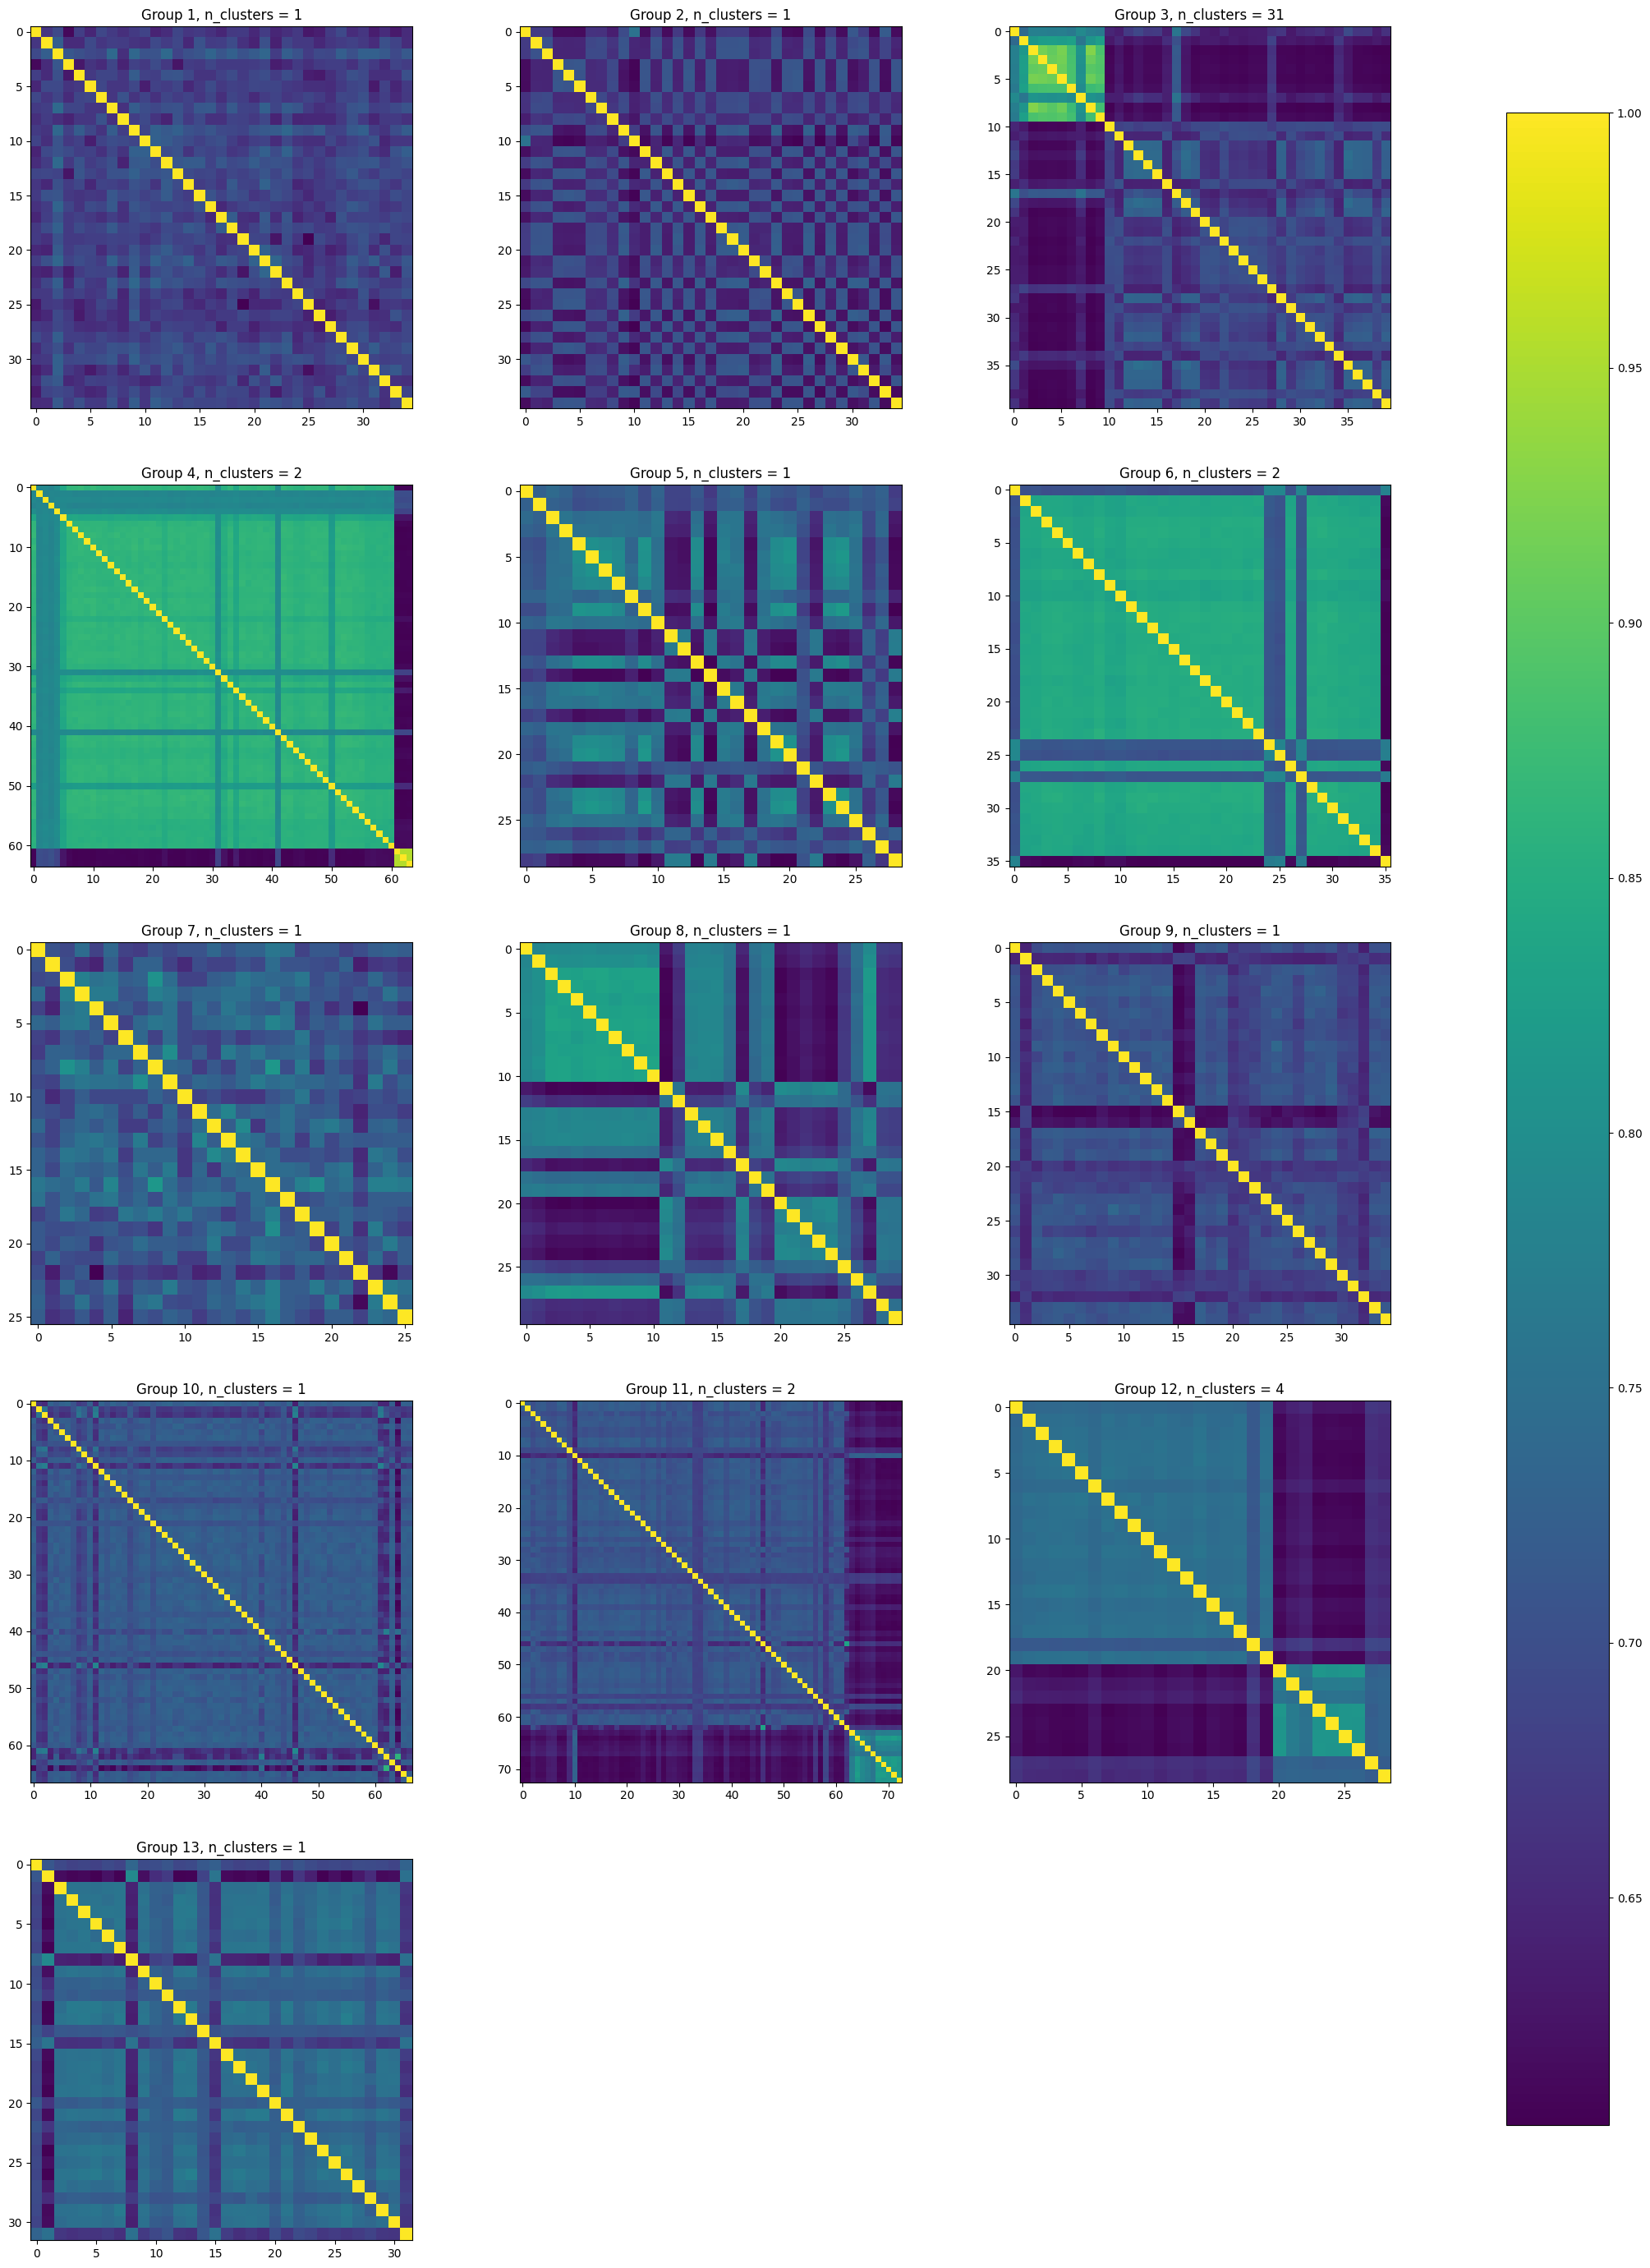

In [ ]:
#Plotting the posterior similarity matrices
fig, axes = plt.subplots(5, 3, figsize = (25, 35))
axes = axes.flatten()
for j in range(J):
  plot = axes[j].imshow(psm_s[j][orders[j]][:, orders[j]], cmap = 'viridis') #, vmin = 0, vmax = 1 ???
  axes[j].set_title(f'Group {j + 1}, n_clusters = {np.unique(results[j]).size}')

#Turn off remaining axes (otherwise there is an empty colormap)
for k in range(J, len(axes)):
    axes[k].axis('off')

#Add unique colorbar
fig.subplots_adjust(right = 0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(plot, cax = cbar_ax)

#fig.suptitle('Posterior Similarity Matrices for tables', size = 15)
fig.savefig('PSM_tables.pdf')

In [ ]:
#We need to combine each iteration in DD_iters into a single one-dimensional array and remove the -2's
DD_pooled_iters = []
for t in range(T):
  DD_pooled_iters.append(DD_iters[t].flatten()[DD_iters[t].flatten() != -2])
DD_pooled_iters = np.array(DD_pooled_iters)

In [ ]:
#Now we can run Salso to compute the optimal partition and the posterior similarity matrix
#Activate conversion
numpy2ri.activate()
#Send to R
r_mat = robjects.r.matrix(DD_pooled_iters, nrow = DD_pooled_iters.shape[0], ncol = DD_pooled_iters.shape[1])
#Run SALSO
opt_part_global = np.array(list(salso.salso(r_mat)))
#Computing posterior similarity matrices
psm_s_global = salso.psm(r_mat)
orders_global = np.argsort(opt_part_global)

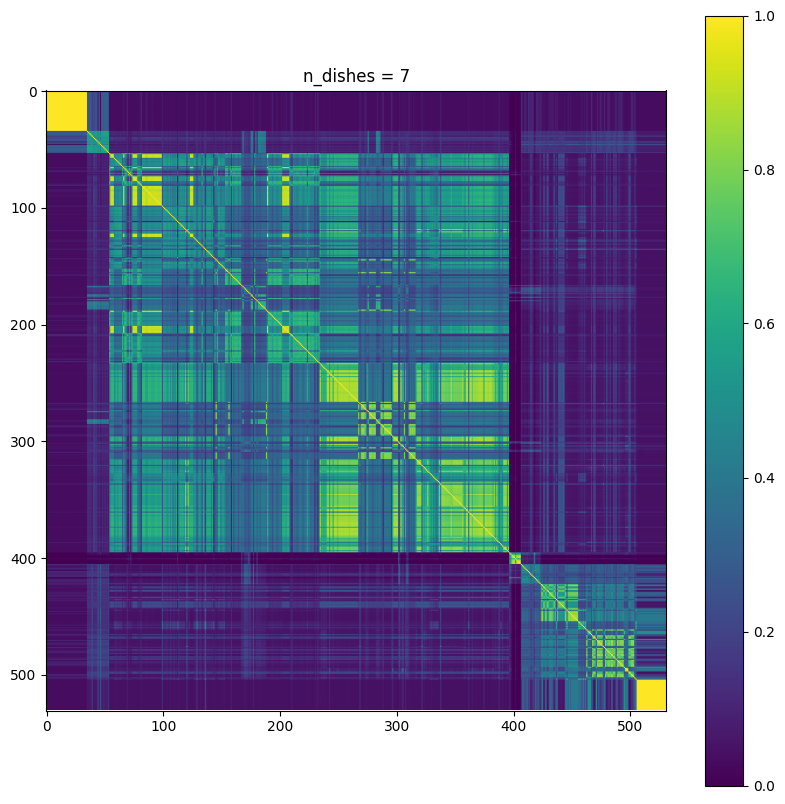

In [ ]:
#Now we can finally plot the psm ordered according to the optimal partition
fig, axes = plt.subplots(1, 1, figsize = (10, 10))
plot = axes.imshow(psm_s_global[orders_global][:, orders_global])
plt.colorbar(plot)
axes.set_title(f'n_dishes = {np.unique(opt_part_global).size}')
#fig.suptitle(f'Posterior Similarity Matrices for dishes, D = {np.unique(opt_part_global).size}', size = 15)
fig.savefig('PSM_dishes.pdf')

### Other plots

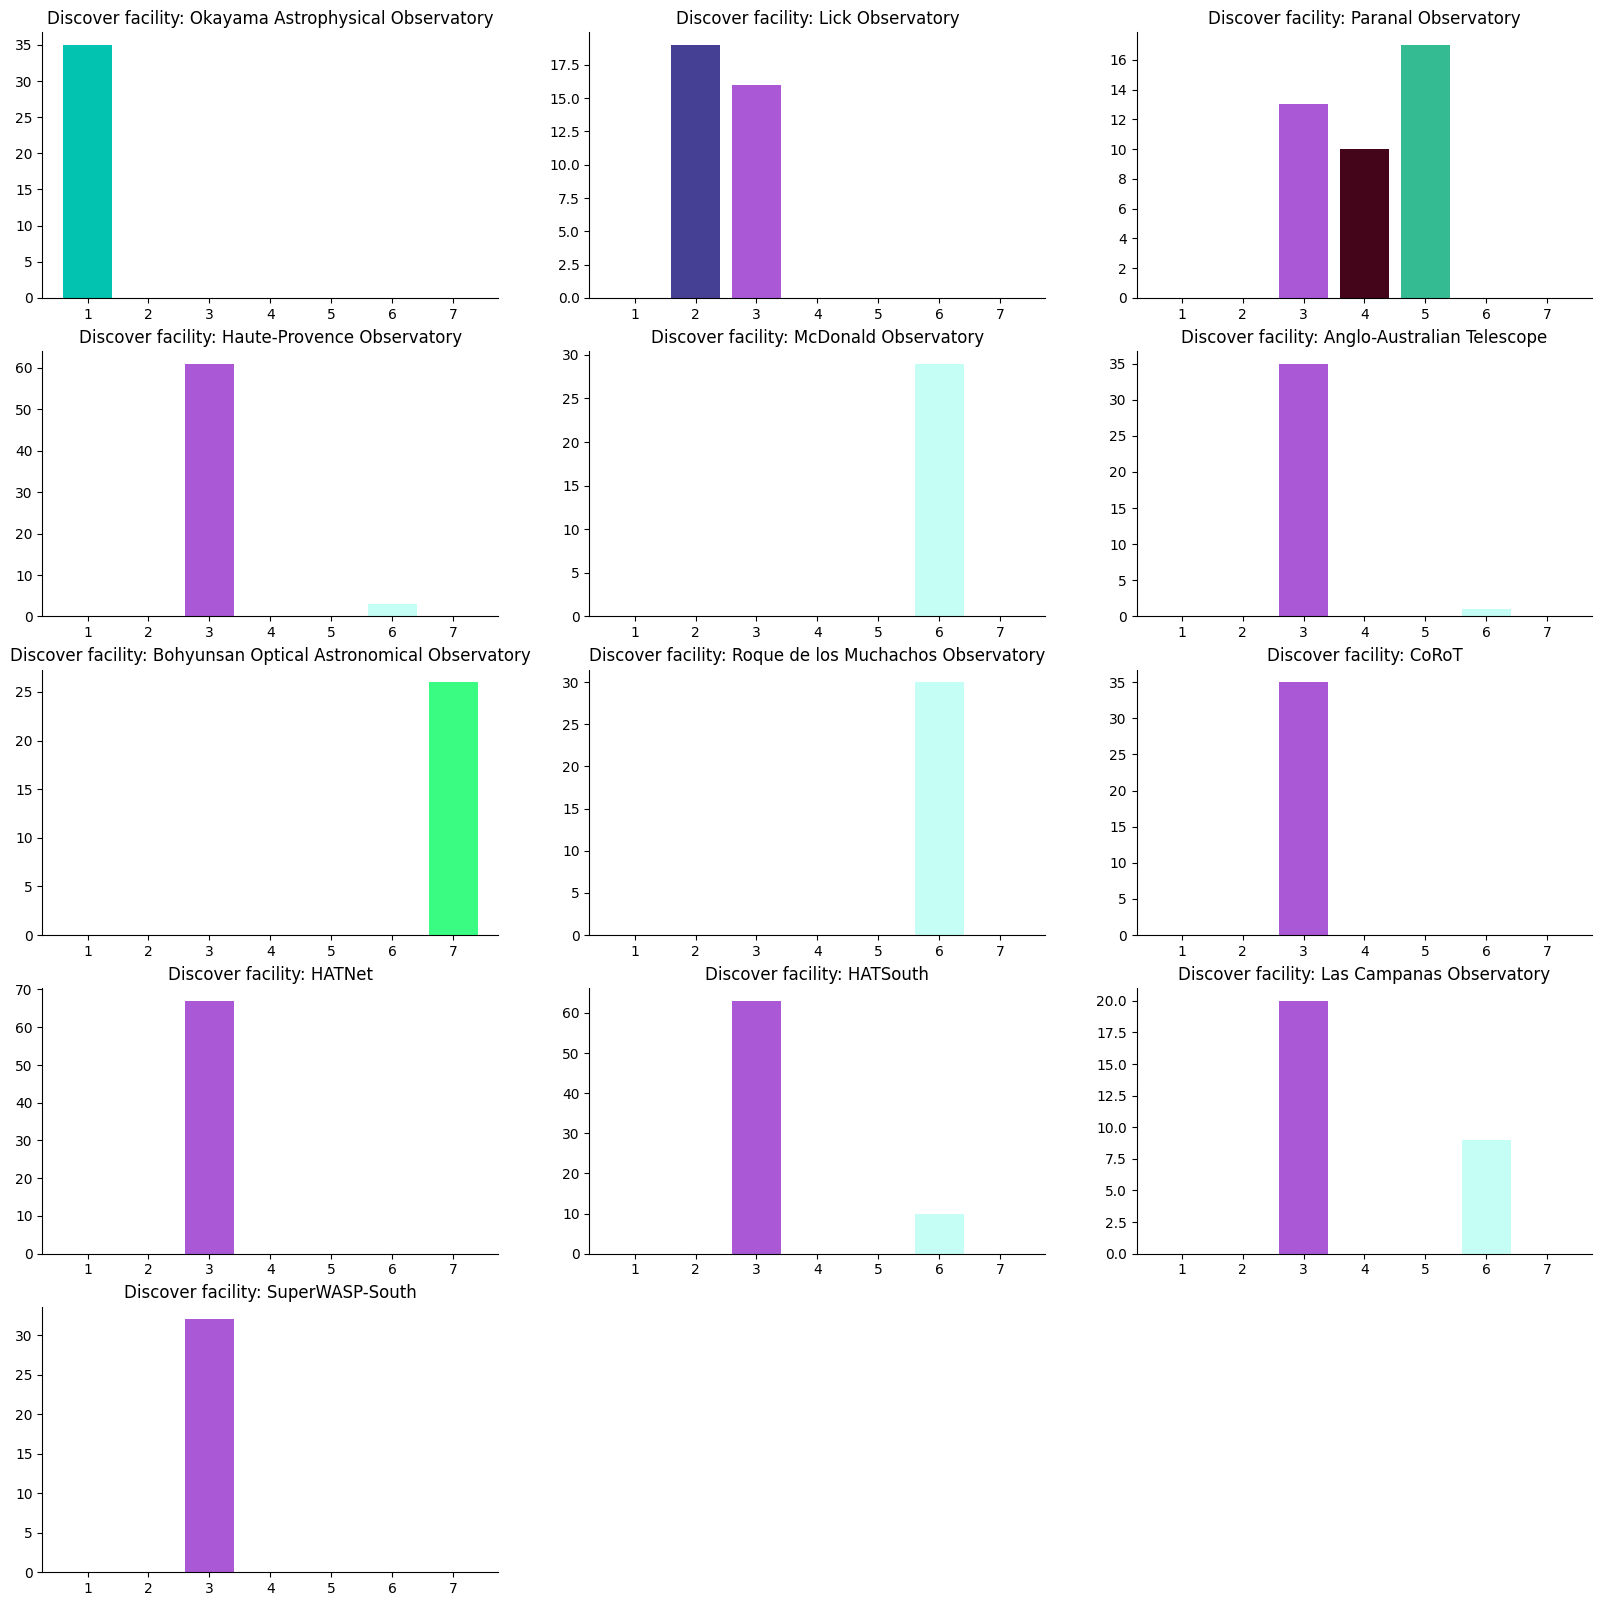

In [ ]:
#We extract dishes assignment for each group according to the optimal partition
indexing = [0]
indexing.extend(sample_sizes)
indexing = np.cumsum(indexing)
dish_assignment = []
for j in range(J):
  dish_assignment.append(opt_part_global[indexing[j]:indexing[j+1]])

#Now we plot
fig, axes = plt.subplots(5, 3, figsize = (20, 20))
axes = axes.flatten()

colors = ['#{:06x}'.format(random.randint(0, 0xFFFFFF)) for i in range(np.unique(opt_part_global).size)]
x = [i + 1 for i in range(np.unique(opt_part_global).size)]
mapping_inverted = {values : keys for keys, values in mapping.items()}
cls = []
for j in range(J):
  height = [0 for i in range(np.unique(opt_part_global).size)]
  cl, counts = np.unique(dish_assignment[j], return_counts = True)
  cls.append(cl) #needed for the plot below to get the right colors for each histogram piece
  for i in range(len(cl)):
    height[cl[i] - 1] = counts[i]
  axes[j].bar(x, height, color = colors)
  axes[j].spines['top'].set_visible(False)
  axes[j].spines['right'].set_visible(False)
  axes[j].set_title(f'Discover facility: {mapping_inverted[j]}')
#fig.suptitle('Number of dishes and their cardinalities for each group, according to the optimal partition', size = 15)

#Turn off empty axes
for ax in axes[J:]:
  ax.set_visible(False)

fig.savefig('dishes_card_across_groups.pdf')

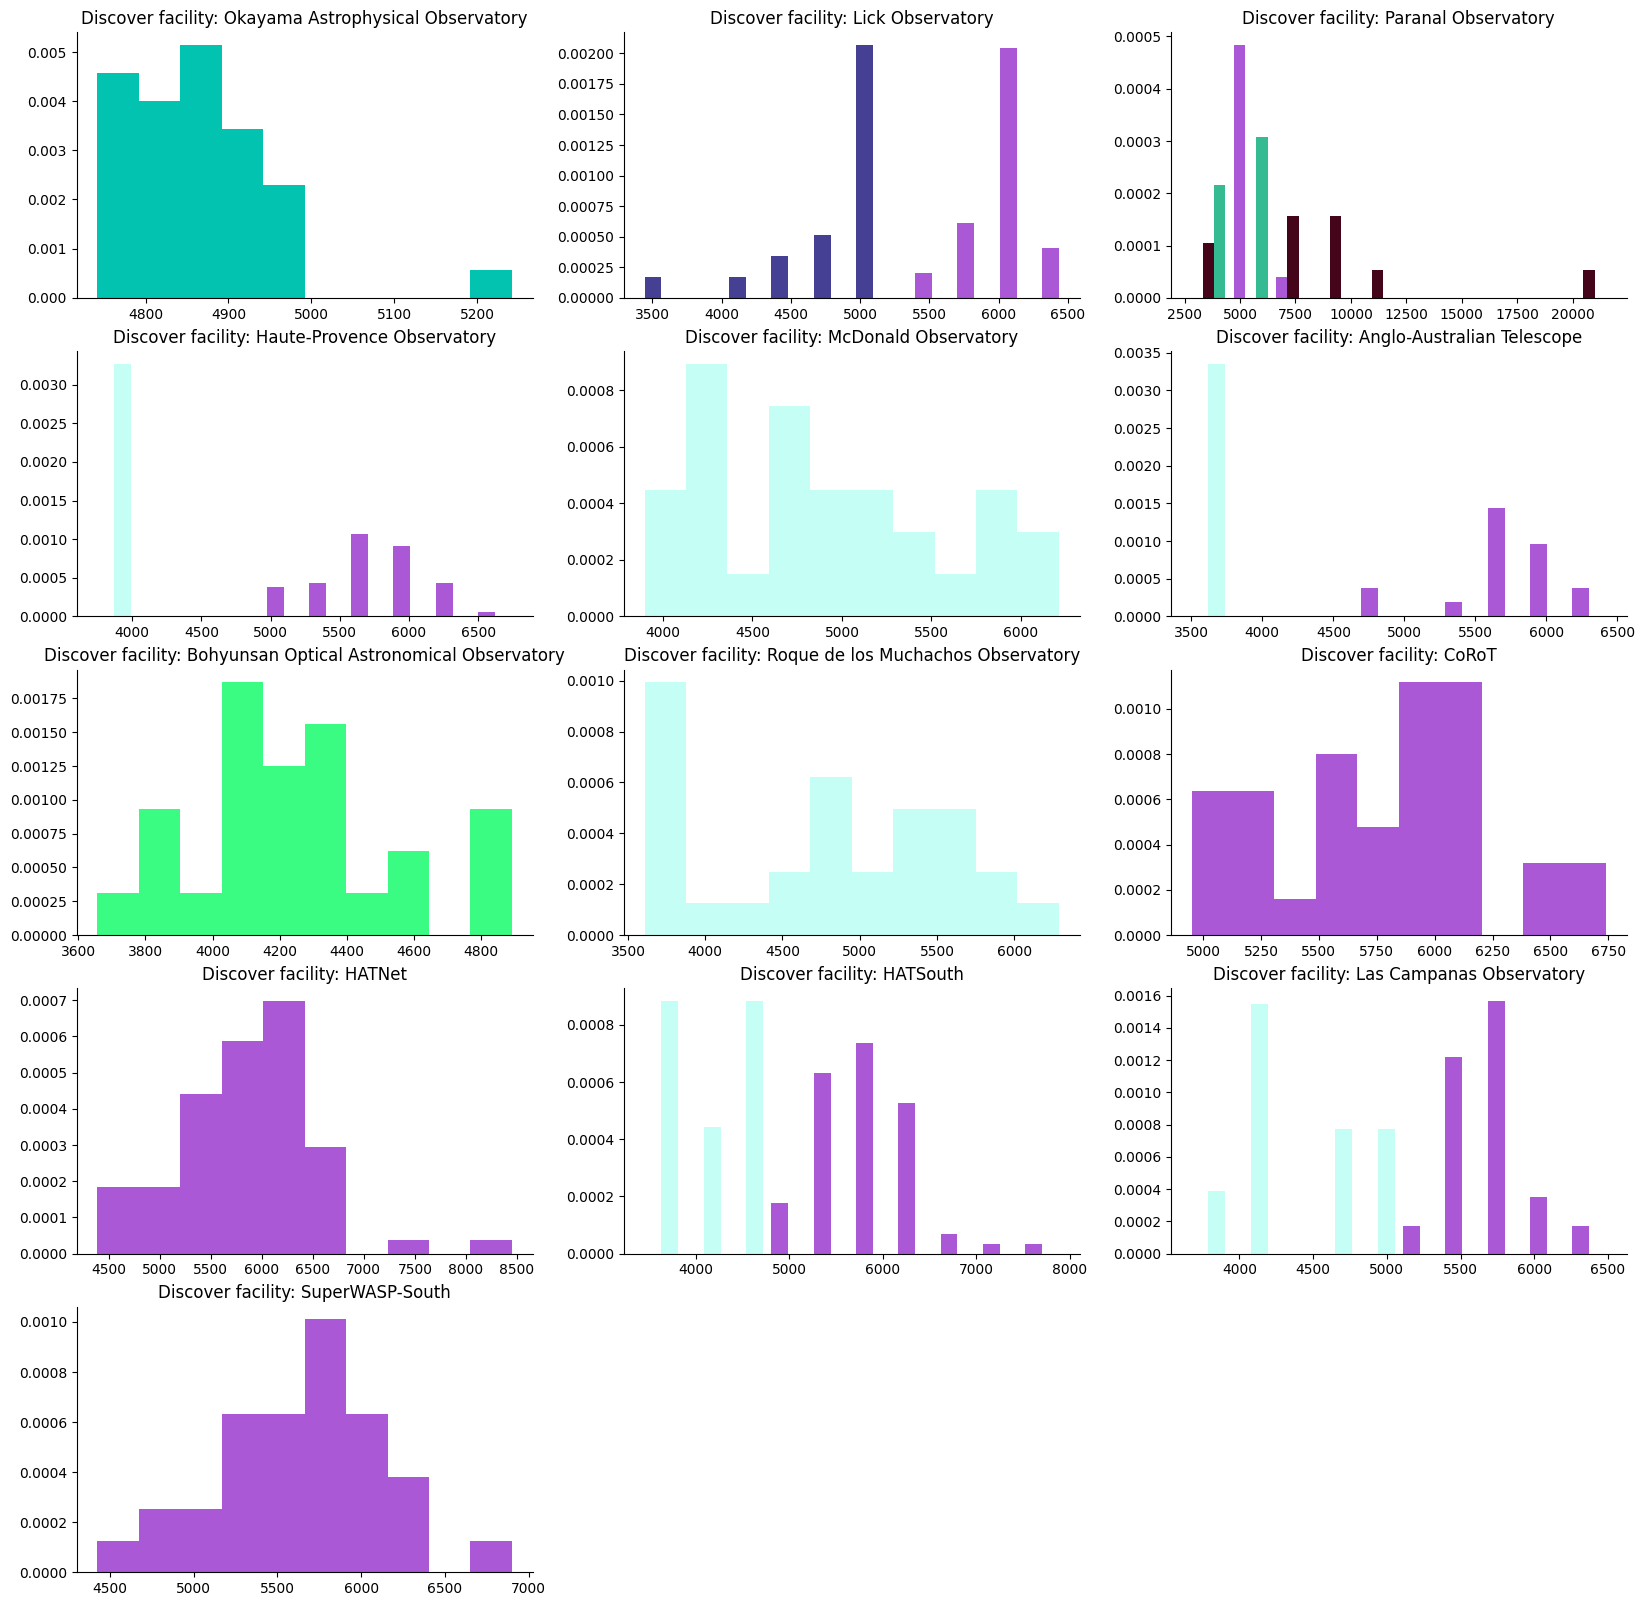

In [ ]:
#Similarly to the above plot, we now colour the histogram of the data samples according to assigned (optimal) dishes, for each group
#We now convert the optimal partition in another format, which is easier to deal with for plotting histograms
part_sample = converter(dish_assignment)
#Now we plot
fig, axes = plt.subplots(5, 3, figsize = (20, 20))
axes = axes.flatten()
for j in range(J):
  sub_samp = []
  sub_col = []
  for i in range(len(part_sample[j])):
    sub_samp.append(groups[j][part_sample[j][i]])
    sub_col.append(colors[cls[j][i] - 1])
  axes[j].hist(sub_samp, color = sub_col, density = True)
  axes[j].spines['top'].set_visible(False)
  axes[j].spines['right'].set_visible(False)
  axes[j].set_title(f'Discover facility: {mapping_inverted[j]}')
#fig.suptitle('Histogram of groups samples data, colored according to the optimal dishes partition', size = 15)

#Turn off empty axes
for ax in axes[J:]:
  ax.set_visible(False)

fig.savefig('group_hist_according_to_dishes.pdf')

In [ ]:
#We want to find the observations belonging to each dish
#First of all we pool the observations together and we do the same with the dish assignments (we pool the groups into a single array)
obs_pool = []
dish_assignment_pool = []
for i in range(len(groups)):
  obs_pool.extend(groups[i])
  dish_assignment_pool.extend(dish_assignment[i])
obs_pool = np.array(obs_pool)

#Then we convert the format of dish_assignment_pool into the other one
part_sample_pool = []
for dish in np.unique(dish_assignment_pool):
  part_sample_pool.append(np.where(dish_assignment_pool == dish)[0].tolist())

for i in range(len(part_sample_pool)):
  print(f'Group {i + 1} -', 'Mean:', np.mean(obs_pool[part_sample_pool[i]]), 'StD:', np.std(obs_pool[part_sample_pool[i]]))

Group 1 - Mean: 4866.142857142857 StD: 91.79391291899258
Group 2 - Mean: 4791.1578947368425 StD: 422.40966186591083
Group 3 - Mean: 5804.516432748538 StD: 497.94899680944434
Group 4 - Mean: 8771.342999999999 StD: 4972.922420151052
Group 5 - Mean: 4506.707647058824 StD: 521.1854975131149
Group 6 - Mean: 4641.651219512195 StD: 747.2413281520988
Group 7 - Mean: 4230.8961538461535 StD: 312.35185840129964


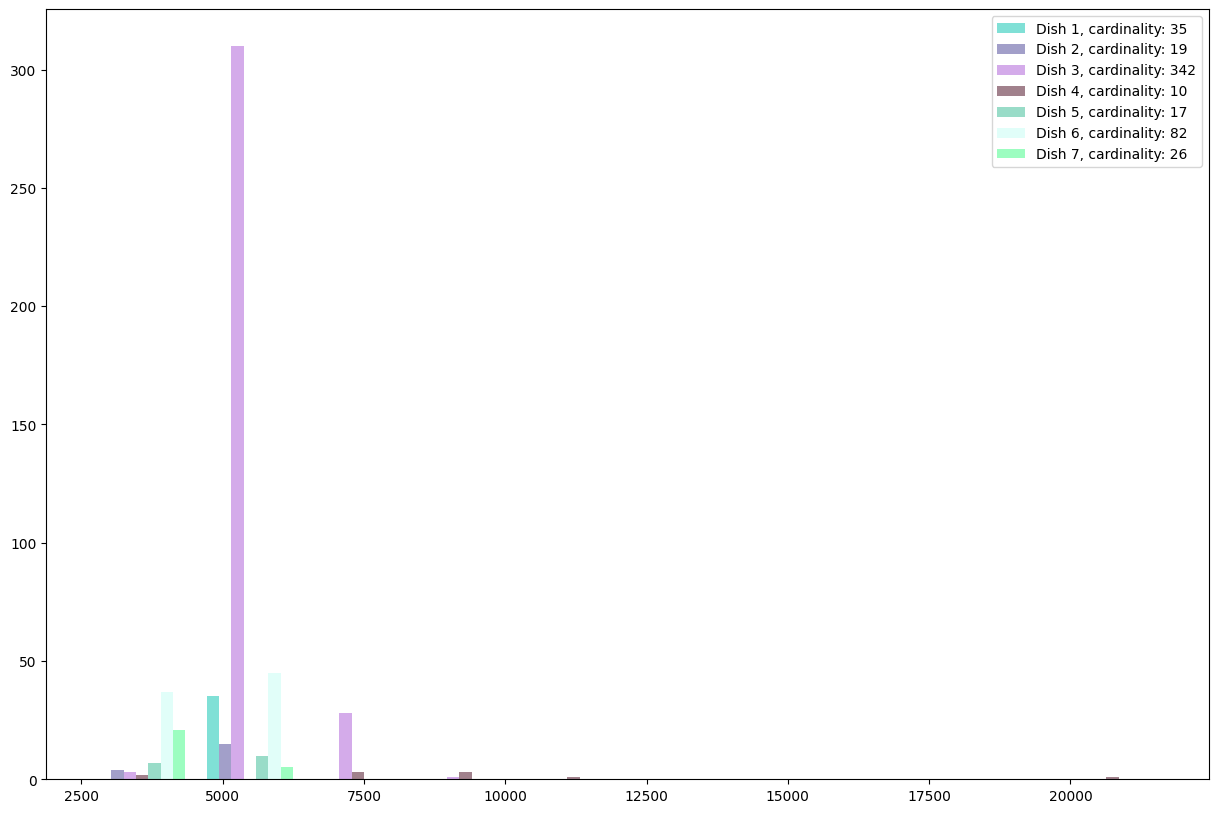

In [ ]:
#Now we plot the data histogram, subdivided by dishes
list_hist = []
for i in range(len(part_sample_pool)):
  list_hist.append(obs_pool[part_sample_pool[i]]) #since we start from 1 for dishes, not 0

fig, ax = plt.subplots(1, 1, figsize = (15, 10))
ax.hist(list_hist, color = colors, alpha = .5)
ax.legend([f'Dish {i + 1}, cardinality: {len(part_sample_pool[i])}' for i in range(len(part_sample_pool))])
fig.savefig('Hist_dishes.pdf')

### Density Estimation

In [ ]:
#Creating a (good) support for density estimation
n = 100
data = []
for values in groups.values():
  data.extend(values)
support = np.linspace(min(data), max(data), n)

#Discard burn-in
burn_in = 500
C_iters = C_iters[burn_in:]
DD_iters = DD_iters[burn_in:]
Q_iters = Q_iters[burn_in:]
L_iters = L_iters[burn_in:]
F_iters = F_iters[burn_in:]
T = T - burn_in
density_estim = {j : posterior_predictive_pdf(support, j, groups) for j in range(J)}

#KDE
kde_evals = []
for j in range(J):
  kde = ss.gaussian_kde(groups[j])
  kde_evals.append(kde.pdf(support))

In [ ]:
#Creating colormap and importance for rugs plot
col_mask = copy.deepcopy(dish_assignment)
importance = copy.deepcopy(dish_assignment)
for j in range(J):
  for i in range(np.unique(opt_part_global).size):
    #Updating color mask
    col_mask[j] = np.array(col_mask[j], dtype = 'str') #we need to convert each array in the list in strings otherwise the next line won't work
    col_mask[j][col_mask[j] == f'{i + 1}'] = colors[i] #we now start from i + 1, since the cluster indices start from 1
    #Updating importance array
    importance[j][importance[j] == i + 1] = len(importance[j][importance[j] == i + 1]) #importance value is given by the number of observations in each group assigned to dish i

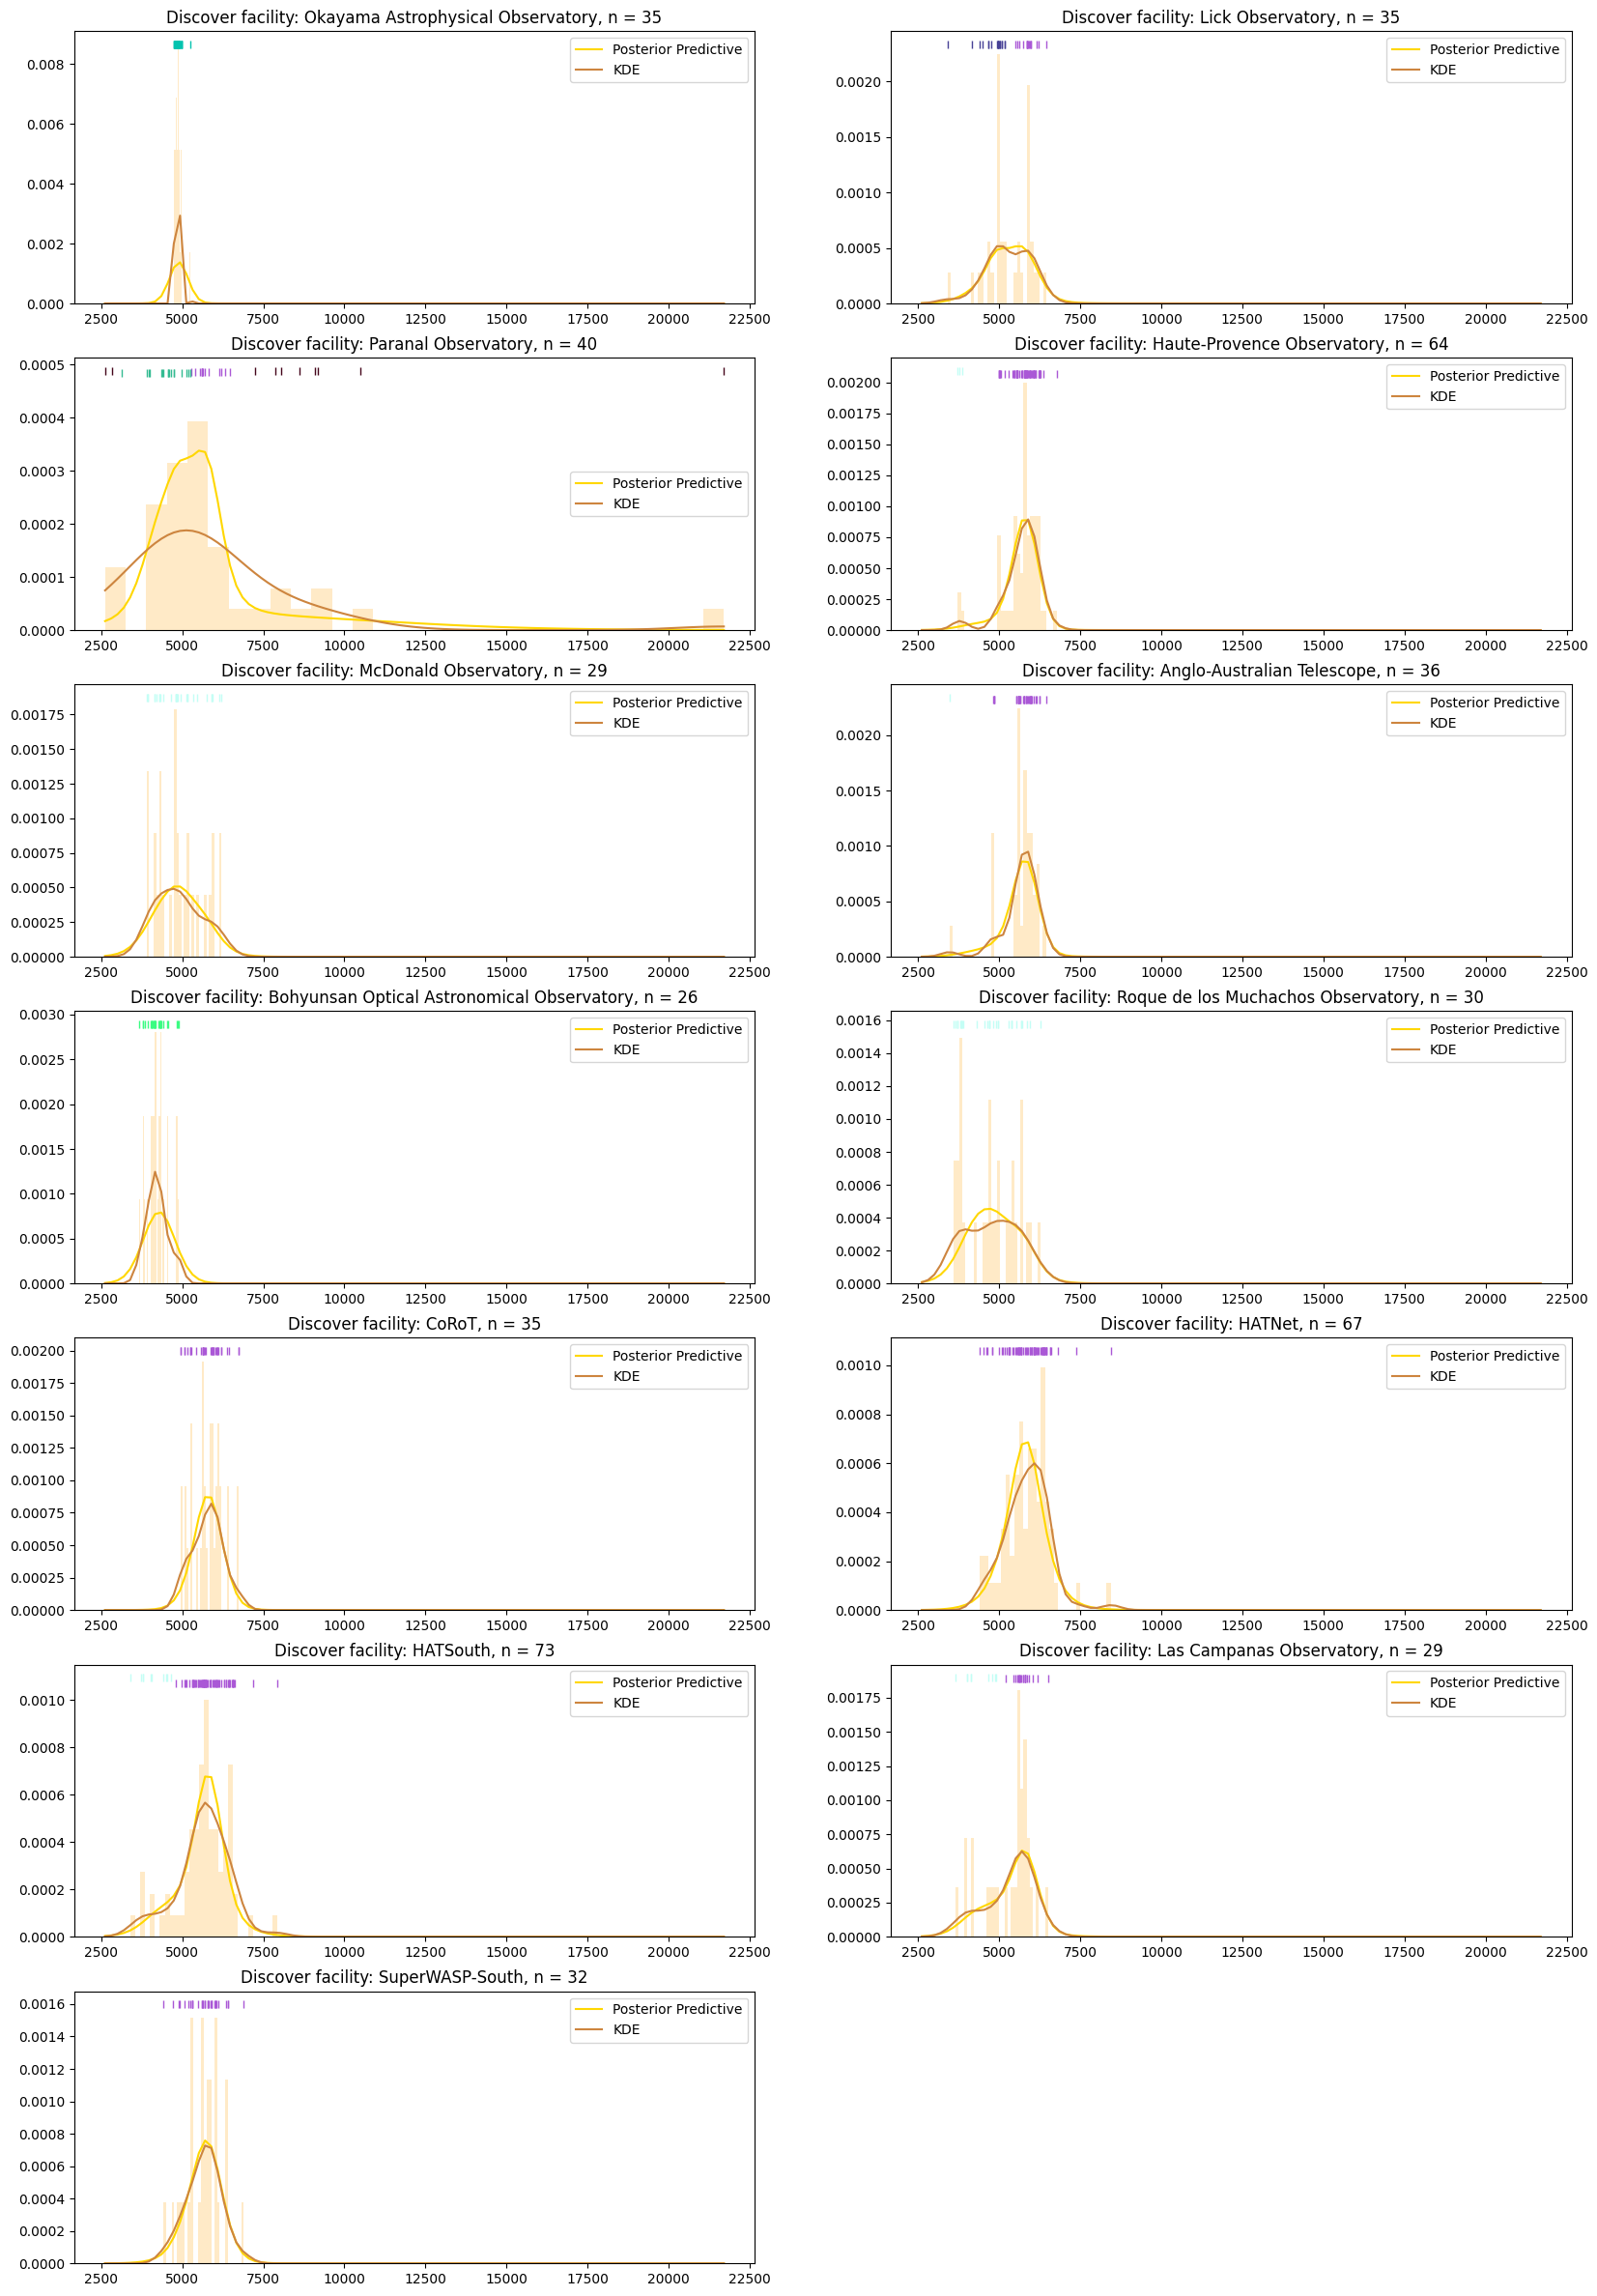

In [ ]:
#Plotting
fig, axes = plt.subplots(nrows = 7, ncols = 2, figsize = (20, 30))
axes = axes.flatten() #to flatten it, since it is a 2x2 matrix
for j in range(J):
  heights, bins, patches = axes[j].hist(groups[j], bins = 30, density = True, color = 'moccasin', alpha = .75)
  axes[j].plot(support, density_estim[j], color = 'gold')
  axes[j].plot(support, kde_evals[j], color = 'peru')
  maxx = max(max(density_estim[j]), max(heights), max(kde_evals[j]))
  for i in range(sample_sizes[j]):
      axes[j].plot(groups[j][i], maxx + .0001 - (importance[j][i]*0.0000005), '|', color = col_mask[j][i])
  axes[j].legend(['Posterior Predictive', 'KDE'])
  axes[j].set_title(f'Discover facility: {mapping_inverted[j]}, n = {sample_sizes[j]}')
#fig.suptitle('Estimated density: Posterior predictive vs. KDE on data histograms', size = 21)

#Turn off empty axes
for ax in axes[J:]:
  ax.set_visible(False)

fig.savefig('Dens_estim_pred_vs_KDE.pdf')

# Real Data Example - CPP, link: https://atlaslongitudinaldatasets.ac.uk/datasets/cpp

In [ ]:
os.chdir(r'/content/drive/MyDrive/Colab Notebooks/Thesis/hierarchical/plots/Real data/cpp')

In [ ]:
#Importing the data set
dataset = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Thesis/hierarchical/data sets/CPP/CPP.csv')

In [ ]:
#We have 12 groups
dataset.hosp.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [ ]:
#Remove Nans from the column of interest
dataset = dataset[~dataset.weight.isnull()]

In [ ]:
#We extract the different groups observations
groups = {i : np.array(dataset.weight[dataset.hosp == i + 1]) for i in range(len(dataset.hosp.unique()))}

In [ ]:
#We check sample sizes
for i in range(len(dataset.hosp.unique())):
  print(i, len(groups[i]))

0 481
1 124
2 150
3 77
4 205
5 153
6 141
7 141
8 117
9 384
10 151
11 188


In [ ]:
#Since there are way too many observations, we trim each sample randomly to have a size between 50-65
for i in range(len(dataset.hosp.unique())):
  if len(groups[i]) >= 100:
    ran_size = np.random.randint(50, 65)
    groups[i] = np.random.choice(groups[i], size = ran_size, replace = False)

0 64
1 54
2 61
3 77
4 61
5 50
6 50
7 54
8 61
9 57
10 56
11 56


(array([[0.00000000e+00, 0.00000000e+00, 1.44075611e-04, 3.96207930e-04,
         2.52132319e-04, 7.20378054e-04, 5.76302444e-04, 2.16113416e-04,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.53781398e-05,
         2.98823489e-04, 8.11092328e-04, 8.53781398e-04, 2.56134419e-04,
         0.00000000e+00, 0.00000000e+00],
        [7.55806483e-05, 0.00000000e+00, 7.55806483e-05, 2.64532269e-04,
         6.42435511e-04, 7.18016159e-04, 4.15693566e-04, 7.55806483e-05,
         3.77903242e-05, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.49688946e-04,
         6.88569153e-04, 8.98133678e-04, 4.49066839e-04, 1.19751157e-04,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 7.55806483e-05, 4.15693566e-04,
         6.80225835e-04, 6.04645187e-04, 4.15693566e-04, 1.13370972e-04,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 9.22083910e-05, 2.3

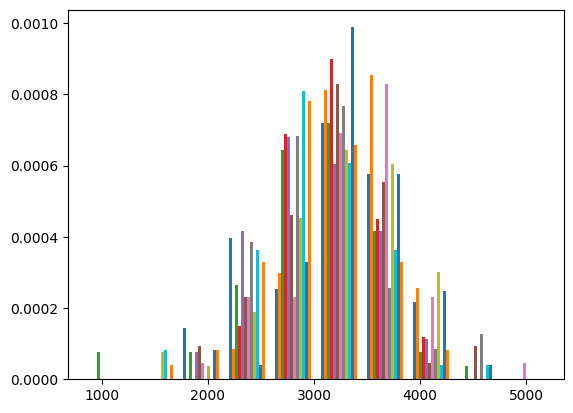

In [ ]:
#We check again and store how many measurements we have for each group/polulation
sample_sizes = []
for key, group in groups.items():
  print(key, len(group))
  sample_sizes.append(len(group))

#We also check normality of the data
plt.hist(groups.values(), density = True)

In [ ]:
#We compute sample stats and use them for hyperparameters choice
obs_pool = []
for obs in groups.values():
  obs_pool.extend(obs)
global_mean, global_var = np.mean(obs_pool), np.var(obs_pool)

#Parameters initialization
gamma = .35
gamma_0 = .5
J = len(groups) #number of groups
T = 5000
a = 3
b = global_var #PROVARE A USARE PRIOR NON INFORMATIVA
mu_0 = global_mean
beta = 1.5
D = 1 #number of global clusters
C = np.zeros(shape = (J, max(sample_sizes)), dtype = 'int32') #(j,i)-th entry is the local cluster of the i-th obs, of the j-th group
for j in range(J):
    I_j = len(groups[j])
    C[j][I_j:] = -2
DD = np.zeros(shape = (J, max(sample_sizes)), dtype = 'int32') #(j,i)-th entry is the global cluster of the i-th obs, of the j-th group
for j in range(J):
    I_j = len(groups[j])
    DD[j][I_j:] = -2
Q = {j : np.array([sample_sizes[j]]) for j in range(J)} #local clusters cardinalities
F = {j : np.array([0]) for j in range(J)} #link between local clusters and their global assigned cluster
L = np.ones(shape = (J, D), dtype = 'int32') #(j,d)-th entry is the number of clusters in j-th group which are then grouped globally under d

#Stuff needed later for diagnostic and density estimation
local_cluster_counter = [[] for j in range(J)]
global_cluster_counter = []
C_iters = []
DD_iters = []
Q_iters = []
L_iters = []
F_iters = []

In [ ]:
#Gibbs sampler
for t in tqdm(range(T)):
    for j in range(J):
        I_j = len(groups[j])
        for i in range(I_j):

            #Remove (j,i)-th observation
            d = DD[j, i] #retrieve global cluster assignment of (j,i)-th observation
            c = C[j, i] #retrieve local cluster assignment of (j,i)-th observation
            Q[j][c] -= 1 #removing (j,i)-th obs. means reducing the cardinality by one
            C[j, i] = -1 #the removed obs. is temporarily assigned index -1 which means it is removed
            DD[j, i] = -1 #the removed obs. is temporarily assigned index -1 which means it is removed

            #If a local cluster becomes empty, we need to update the clusters counts and the indexes
            if Q[j][c] == 0:
                L[j, d] -= 1
                Q[j] = np.delete(Q[j], c) #remove the cluster of card. 0 from the array
                F[j] = np.delete(F[j], c) #remove the global cluster assignment of the now empty local cluster
                C[j][C[j] > c] -= 1 #reducing indexes by one

            #If a global cluster becomes empty, we need to update the clusters counts and the indexes
            r = 0
            while r < L.shape[1]:
                if sum(L[:, r]) == 0:
                    L = np.delete(L, r, 1)
                    D -= 1
                    #It can happen that d is equal to the dish we eliminated, so we need in that case to scale it by one
                    if d == D:
                        d -= 1
                    #Reducing indexes by one both in DD and F
                    DD[DD > r] -= 1
                    for k in range(J):
                        F[k][F[k] > r] -= 1
                    r -= 1 #need to adjust r since L.shape[1] reduces by one
                r += 1

            #Compute the probabilities of assignment
            probs, old_old_delim, new_old_delim = assignment_probs(groups)

            #Sample one of these probabilities and assign the (j,i)-th observation accordingly
            assignment_index = cluster_assign(probs)

            if assignment_index <= old_old_delim:
                C[j, i] = assignment_index
                DD[j, i] = F[j][C[j, i]]
                Q[j][C[j, i]] += 1
            elif assignment_index <= new_old_delim:
                C[j, i] = np.sum(L[j, :]) # = l_j_. we don't need the + 1 since the first cluster has index 0
                d = assignment_index - np.sum(L[j, :]) #retrieve d
                DD[j, i] = d
                Q[j] = np.append(Q[j], 1)
                F[j] = np.append(F[j], d)
                L[j, d] += 1

            else:
                C[j, i] = np.sum(L[j, :]) # = l_j_. we don't need the + 1 since the first cluster has index 0
                DD[j, i] = D #we don't need the + 1 since the first cluster has index 0
                Q[j] = np.append(Q[j], 1)
                F[j] = np.append(F[j], D)
                L = np.hstack((L, np.array([[0]]*J))) #need to update L
                L[j, D] += 1
                D += 1 #however we then need to augment the total number of clusters

    #For diagnostic and density estimation
    C_iters.append(copy.deepcopy(C))
    DD_iters.append(copy.deepcopy(DD))
    Q_iters.append(copy.deepcopy(Q))
    L_iters.append(copy.deepcopy(L))
    F_iters.append(copy.deepcopy(F))
    for j in range(J):
        local_cluster_counter[j].append(len(Q[j]))
    global_cluster_counter.append(D)

100%|██████████| 5000/5000 [3:46:32<00:00,  2.72s/it]


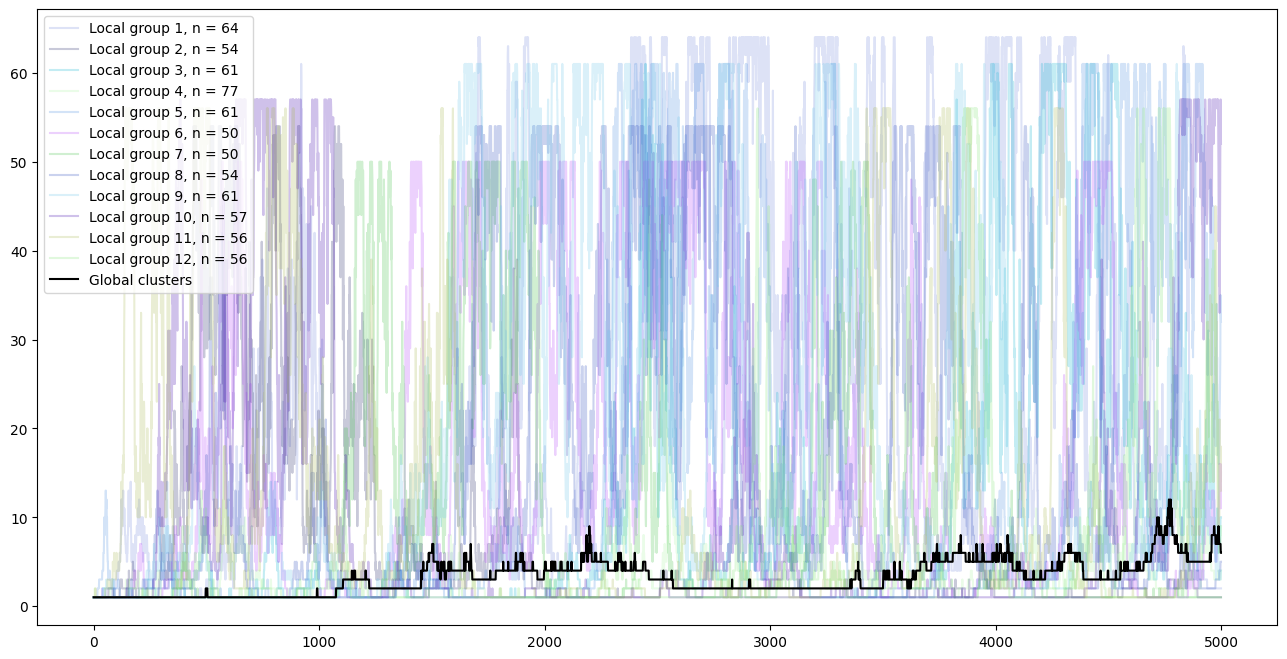

In [ ]:
#Progression of the number of clusters across iterations, both local and global
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16, 8))
for j in range(J):
    color = '#{:06x}'.format(random.randint(0, 0xFFFFFF))
    axes.plot(local_cluster_counter[j], color = color, label = j, alpha = .25)
axes.plot(global_cluster_counter, color = 'black', label = J)
axes.legend([f'Local group {j + 1}, n = {sample_sizes[j]}' if j + 1 <= J else 'Global clusters' for j in range(J + 1)], loc = 'upper left')
#fig.suptitle('Evolution of clusters cardinality among local groups and globally', size = 15)
fig.savefig('Cl_evol.pdf')

### Salso for tables and dishes

In [ ]:
#We do this for the dishes, for each group. First of all we need to reorganise the DD information for each group, across Gibbs iterations
C_iters_per_group = {j : 0 for j in range(J)}
for j in range(J):
    mat = []
    for t in range(T):
        mat.append(C_iters[t][j][C_iters[t][j] != -2])
    C_iters_per_group[j] = np.array(mat)

In [ ]:
#Then we can compute the optimal partitions and posterior similarity matrices for each group
results = []
psm_s = []
orders = [] #to reorder psms
for j in range(J):
    #Activate conversion
    numpy2ri.activate()
    #Send to R
    r_mat = robjects.r.matrix(C_iters_per_group[j], nrow = C_iters_per_group[j].shape[0], ncol = C_iters_per_group[j].shape[1])
    #Run SALSO
    opt_part = np.array(list(salso.salso(r_mat)))
    results.append(opt_part)
    #Computing posterior similarity matrices
    psm_s.append(salso.psm(r_mat))
    orders.append(np.argsort(opt_part))

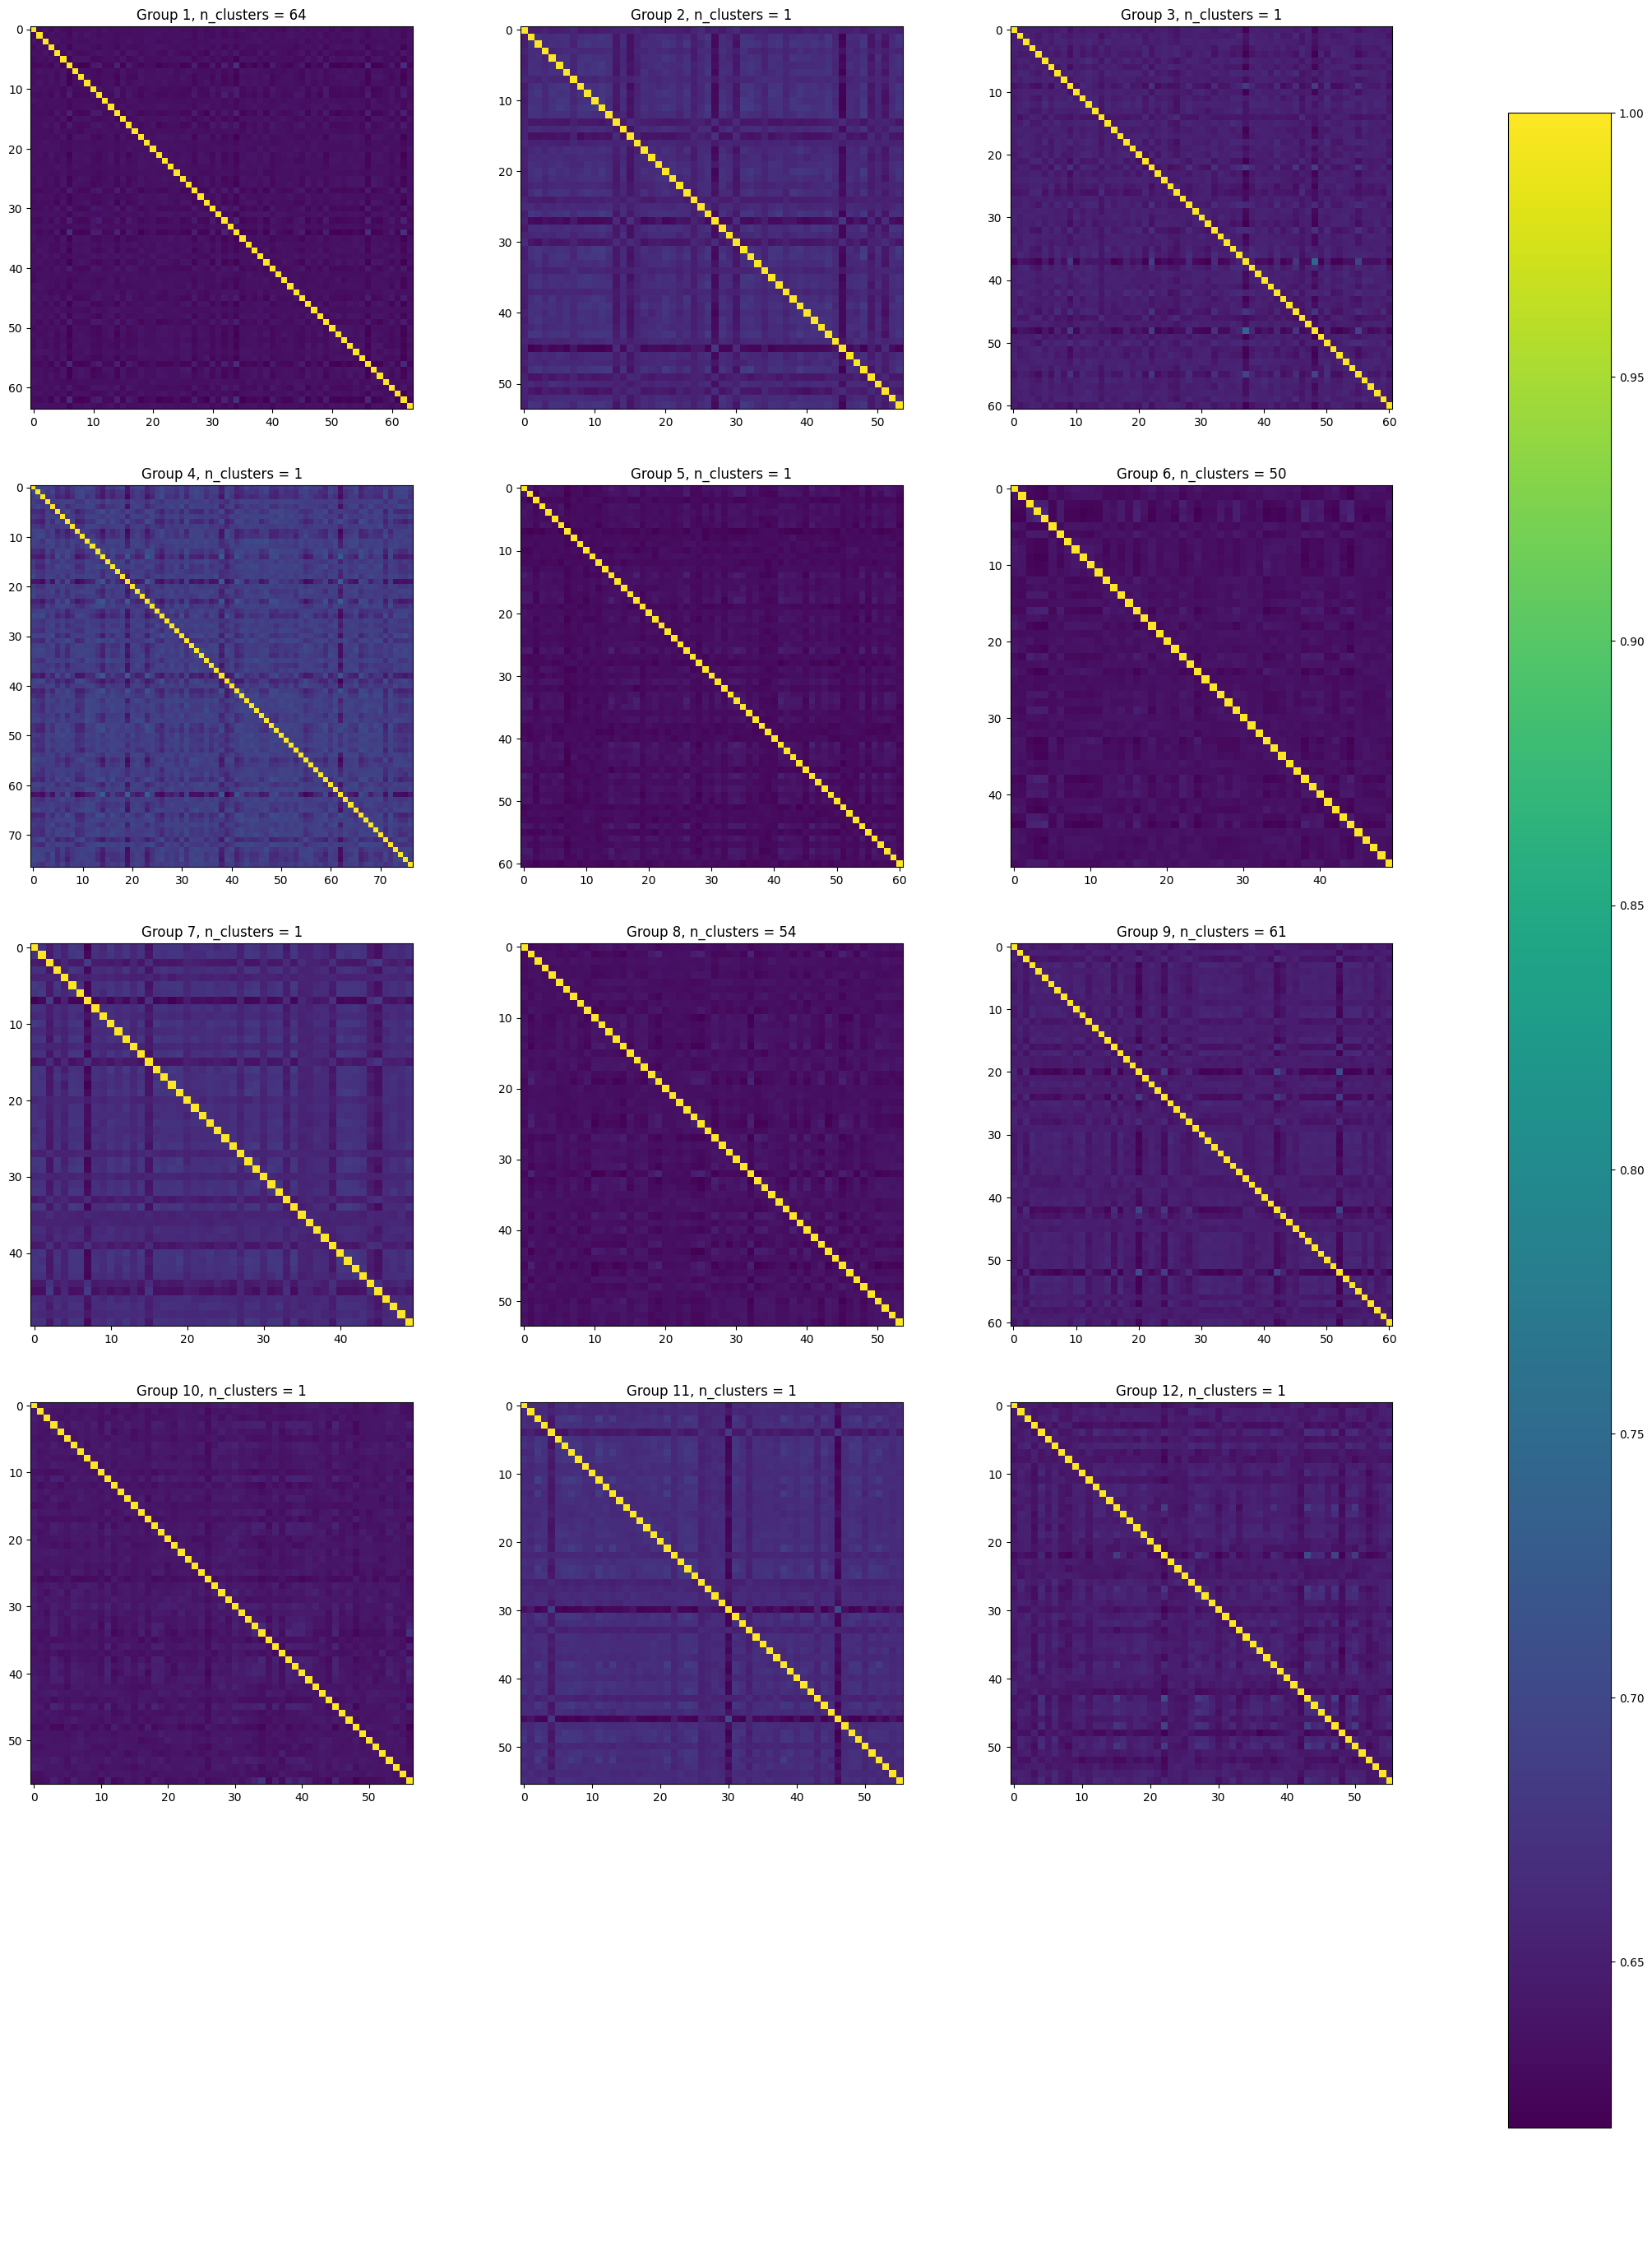

In [ ]:
#Plotting the posterior similarity matrices
fig, axes = plt.subplots(5, 3, figsize = (25, 35))
axes = axes.flatten()
for j in range(J):
  plot = axes[j].imshow(psm_s[j][orders[j]][:, orders[j]], cmap = 'viridis') #, vmin = 0, vmax = 1 ???
  axes[j].set_title(f'Group {j + 1}, n_clusters = {np.unique(results[j]).size}')

#Turn off remaining axes (otherwise there is an empty colormap)
for k in range(J, len(axes)):
    axes[k].axis('off')

#Add unique colorbar
fig.subplots_adjust(right = 0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(plot, cax = cbar_ax)

#fig.suptitle('Posterior Similarity Matrices for tables', size = 15)
fig.savefig('PSM_tables.pdf')

In [ ]:
#We need to combine each iteration in DD_iters into a single one-dimensional array and remove the -2's
DD_pooled_iters = []
for t in range(T):
  DD_pooled_iters.append(DD_iters[t].flatten()[DD_iters[t].flatten() != -2])
DD_pooled_iters = np.array(DD_pooled_iters)

In [ ]:
#Now we can run Salso to compute the optimal partition and the posterior similarity matrix
#Activate conversion
numpy2ri.activate()
#Send to R
r_mat = robjects.r.matrix(DD_pooled_iters, nrow = DD_pooled_iters.shape[0], ncol = DD_pooled_iters.shape[1])
#Run SALSO
opt_part_global = np.array(list(salso.salso(r_mat)))
#Computing posterior similarity matrices
psm_s_global = salso.psm(r_mat)
orders_global = np.argsort(opt_part_global)

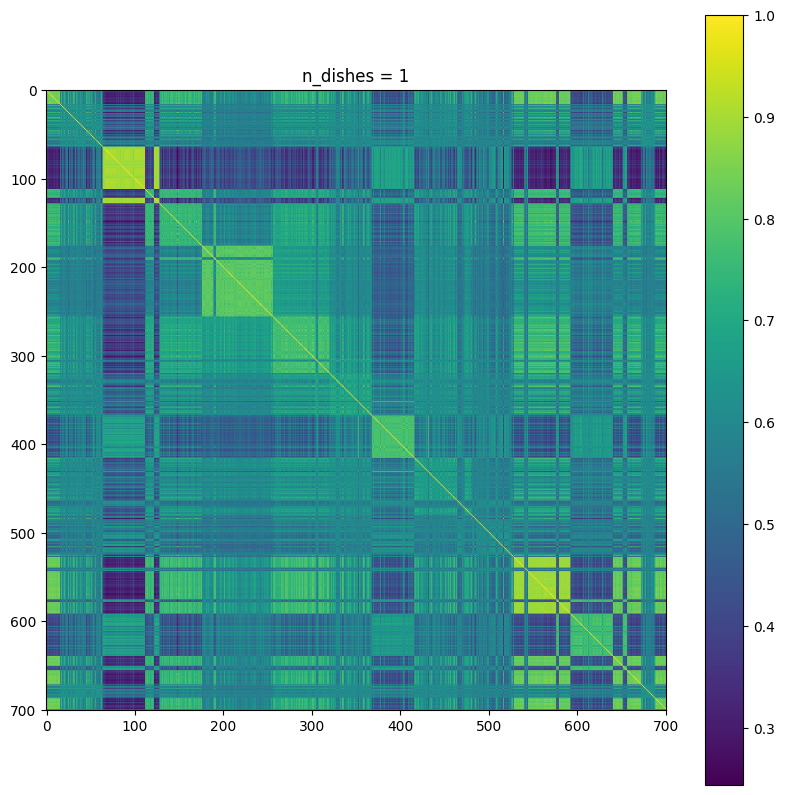

In [ ]:
#Now we can finally plot the psm ordered according to the optimal partition
fig, axes = plt.subplots(1, 1, figsize = (10, 10))
plot = axes.imshow(psm_s_global[orders_global][:, orders_global])
plt.colorbar(plot)
axes.set_title(f'n_dishes = {np.unique(opt_part_global).size}')
#fig.suptitle(f'Posterior Similarity Matrices for dishes, D = {np.unique(opt_part_global).size}', size = 15)
fig.savefig('PSM_dishes.pdf')

### Other plots

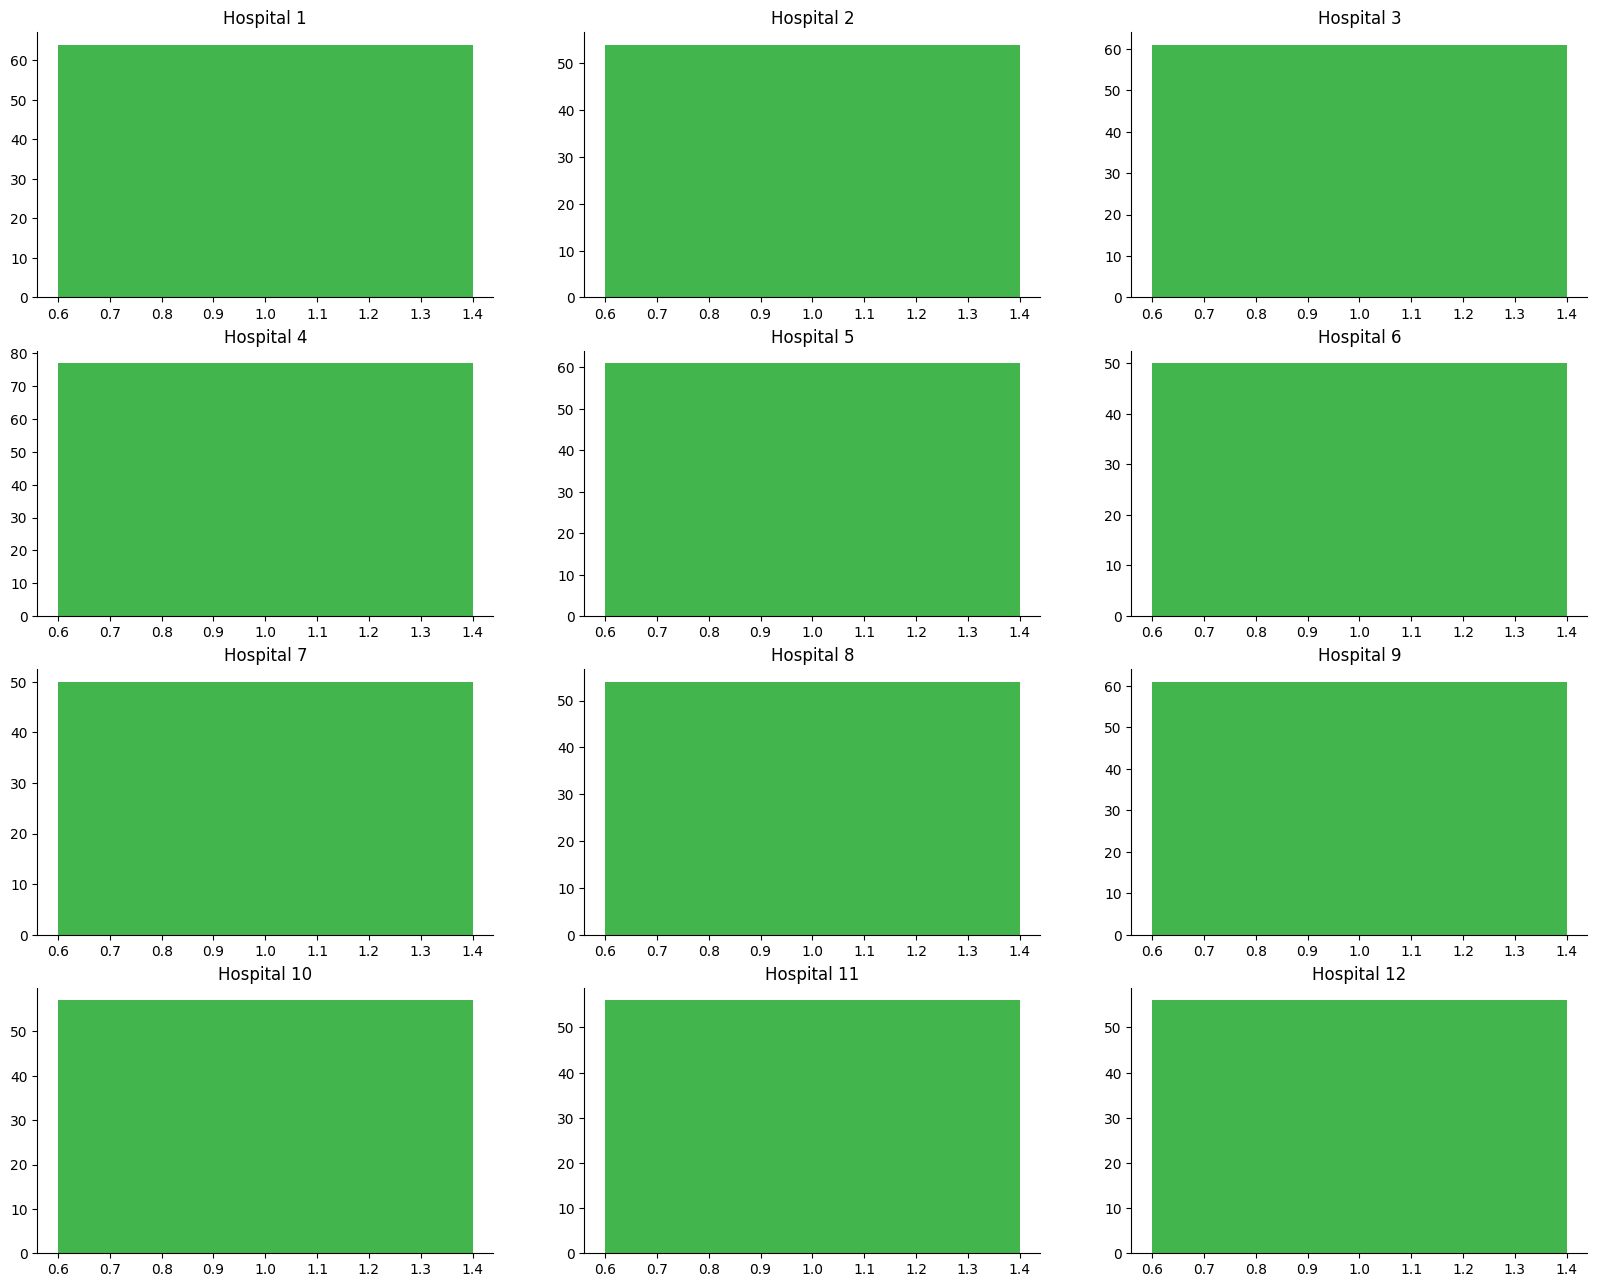

In [ ]:
#We extract dishes assignment for each group according to the optimal partition
indexing = [0]
indexing.extend(sample_sizes)
indexing = np.cumsum(indexing)
dish_assignment = []
for j in range(J):
  dish_assignment.append(opt_part_global[indexing[j]:indexing[j+1]])

#Now we plot
fig, axes = plt.subplots(5, 3, figsize = (20, 20))
axes = axes.flatten()

colors = ['#{:06x}'.format(random.randint(0, 0xFFFFFF)) for i in range(np.unique(opt_part_global).size)]
x = [i + 1 for i in range(np.unique(opt_part_global).size)]
cls = []
for j in range(J):
  height = [0 for i in range(np.unique(opt_part_global).size)]
  cl, counts = np.unique(dish_assignment[j], return_counts = True)
  cls.append(cl) #needed for the plot below to get the right colors for each histogram piece
  for i in range(len(cl)):
    height[cl[i] - 1] = counts[i]
  axes[j].bar(x, height, color = colors)
  axes[j].spines['top'].set_visible(False)
  axes[j].spines['right'].set_visible(False)
  axes[j].set_title(f'Hospital {list(groups.keys())[j] + 1}')
#fig.suptitle('Number of dishes and their cardinalities for each group, according to the optimal partition', size = 15)

#Turn off empty axes
for ax in axes[J:]:
  ax.set_visible(False)

fig.savefig('dishes_card_across_groups.pdf')

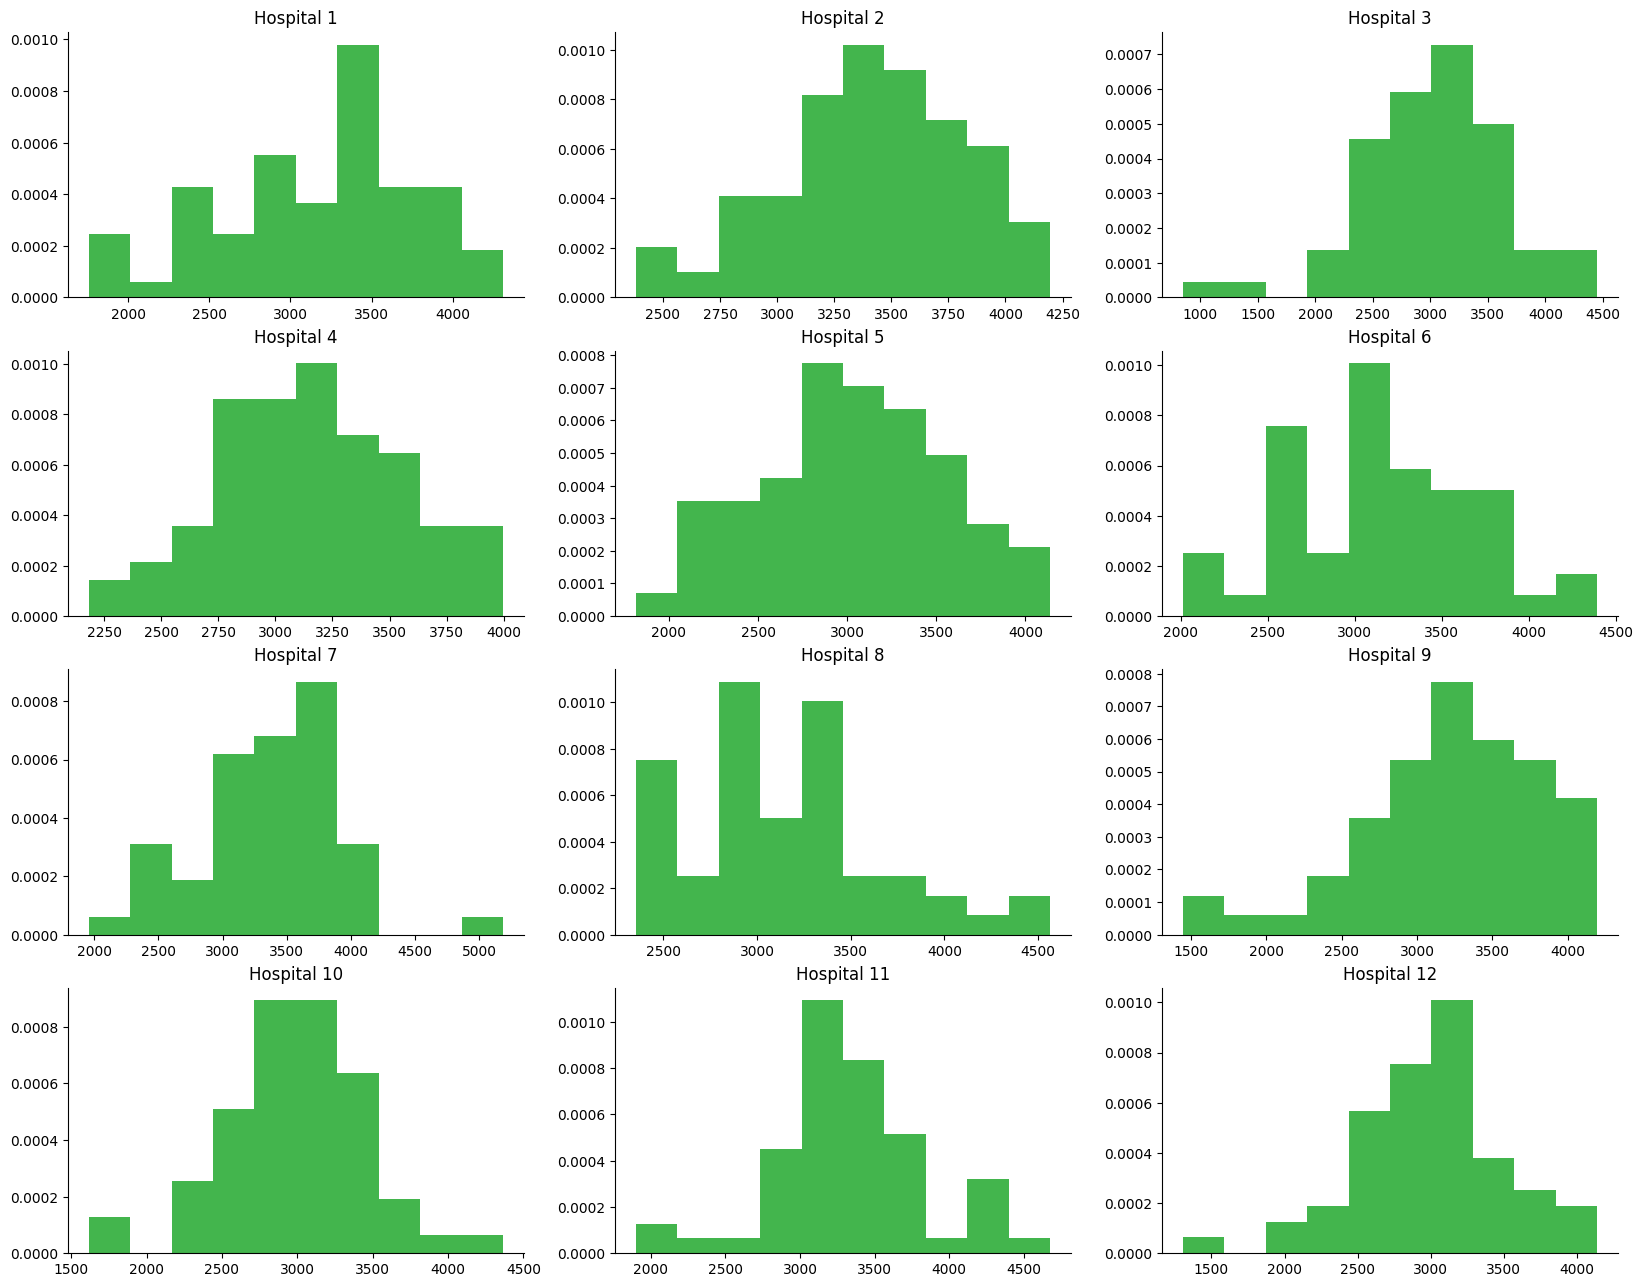

In [ ]:
#Similarly to the above plot, we now colour the histogram of the data samples according to assigned (optimal) dishes, for each group
#We now convert the optimal partition in another format, which is easier to deal with for plotting histograms
part_sample = converter(dish_assignment)
#Now we plot
fig, axes = plt.subplots(5, 3, figsize = (20, 20))
axes = axes.flatten()
for j in range(J):
  sub_samp = []
  sub_col = []
  for i in range(len(part_sample[j])):
    sub_samp.append(groups[j][part_sample[j][i]])
    sub_col.append(colors[cls[j][i] - 1])
  axes[j].hist(sub_samp, color = sub_col, density = True)
  axes[j].spines['top'].set_visible(False)
  axes[j].spines['right'].set_visible(False)
  axes[j].set_title(f'Hospital {list(groups.keys())[j] + 1}')
#fig.suptitle('Histogram of groups samples data, colored according to the optimal dishes partition', size = 15)

#Turn off empty axes
for ax in axes[J:]:
  ax.set_visible(False)

fig.savefig('group_hist_according_to_dishes.pdf')

In [ ]:
#We want to find the observations belonging to each dish
#First of all we pool the observations together and we do the same with the dish assignments (we pool the groups into a single array)
obs_pool = []
dish_assignment_pool = []
for i in range(len(groups)):
  obs_pool.extend(groups[i])
  dish_assignment_pool.extend(dish_assignment[i])
obs_pool = np.array(obs_pool)

#Then we convert the format of dish_assignment_pool into the other one
part_sample_pool = []
for dish in np.unique(dish_assignment_pool):
  part_sample_pool.append(np.where(dish_assignment_pool == dish)[0].tolist())

for i in range(len(part_sample_pool)):
  print(f'Group {i + 1} -', 'Mean:', np.mean(obs_pool[part_sample_pool[i]]), 'StD:', np.std(obs_pool[part_sample_pool[i]]))

Group 1 - Mean: 3159.679029957204 StD: 540.7369736982192


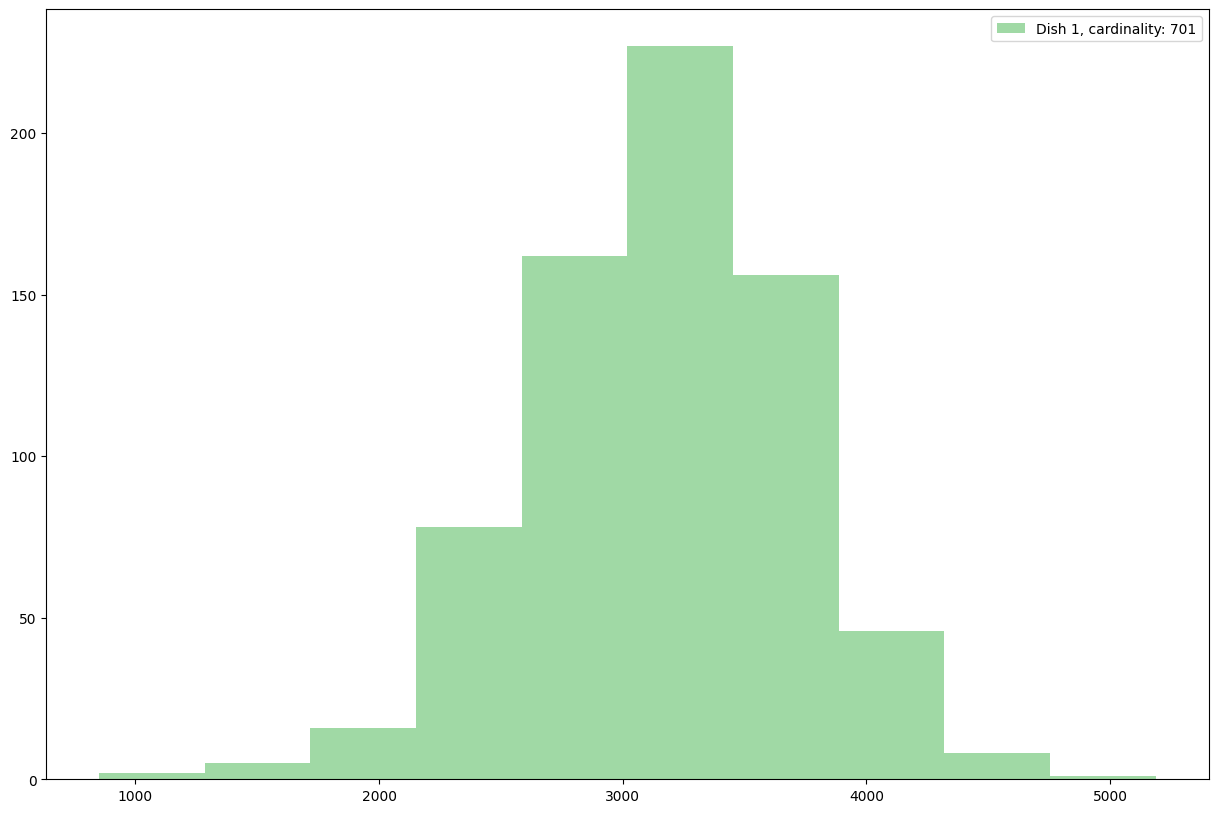

In [ ]:
#Now we plot the data histogram, subdivided by dishes
list_hist = []
for i in range(len(part_sample_pool)):
  list_hist.append(obs_pool[part_sample_pool[i]]) #since we start from 1 for dishes, not 0

fig, ax = plt.subplots(1, 1, figsize = (15, 10))
ax.hist(list_hist, color = colors, alpha = .5)
ax.legend([f'Dish {i + 1}, cardinality: {len(part_sample_pool[i])}' for i in range(len(part_sample_pool))])
fig.savefig('Hist_dishes.pdf')

### Density Estimation

In [ ]:
#Creating a (good) support for density estimation
n = 100
data = []
for values in groups.values():
  data.extend(values)
support = np.linspace(min(data), max(data), n)

#Discard burn-in
burn_in = 1000
C_iters = C_iters[burn_in:]
DD_iters = DD_iters[burn_in:]
Q_iters = Q_iters[burn_in:]
L_iters = L_iters[burn_in:]
F_iters = F_iters[burn_in:]
T = T - burn_in
density_estim = {j : posterior_predictive_pdf(support, j, groups) for j in range(J)}

#KDE
kde_evals = []
for j in range(J):
  kde = ss.gaussian_kde(groups[j])
  kde_evals.append(kde.pdf(support))

In [ ]:
#Creating colormap and importance for rugs plot
col_mask = copy.deepcopy(dish_assignment)
importance = copy.deepcopy(dish_assignment)
for j in range(J):
  for i in range(np.unique(opt_part_global).size):
    #Updating color mask
    col_mask[j] = np.array(col_mask[j], dtype = 'str') #we need to convert each array in the list in strings otherwise the next line won't work
    col_mask[j][col_mask[j] == f'{i + 1}'] = colors[i] #we now start from i + 1, since the cluster indices start from 1
    #Updating importance array
    importance[j][importance[j] == i + 1] = len(importance[j][importance[j] == i + 1]) #importance value is given by the number of observations in each group assigned to dish i

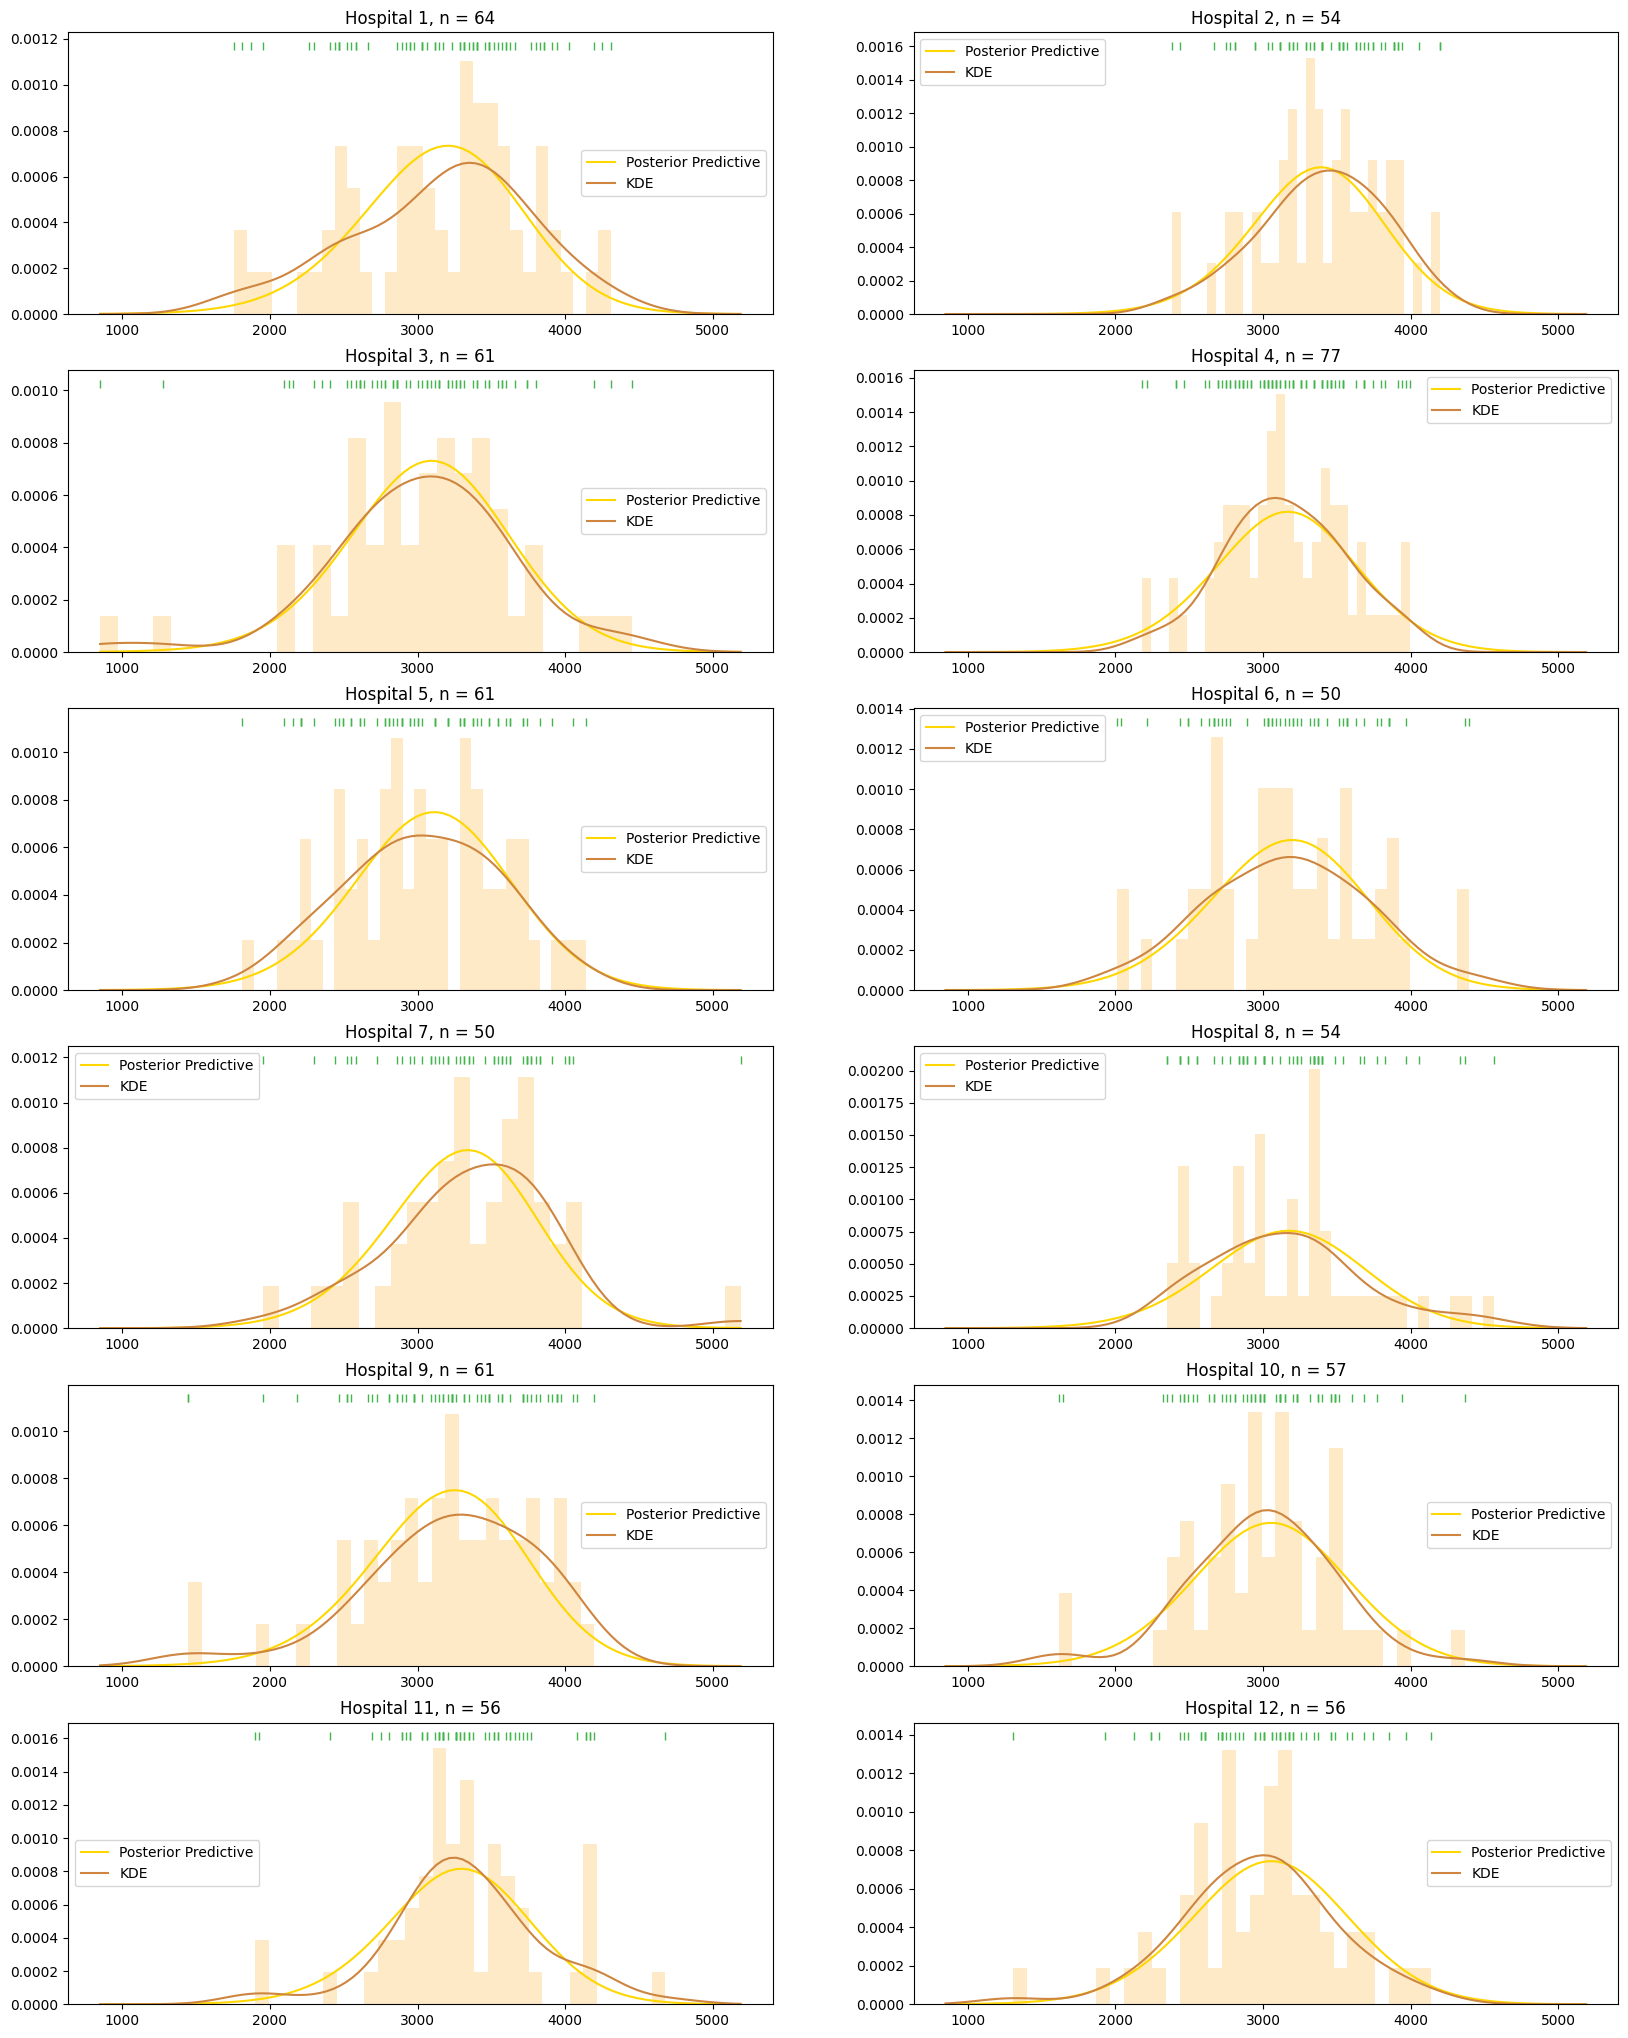

In [ ]:
#Plotting
fig, axes = plt.subplots(nrows = 7, ncols = 2, figsize = (20, 30))
axes = axes.flatten() #to flatten it, since it is a 2x2 matrix
for j in range(J):
  heights, bins, patches = axes[j].hist(groups[j], bins = 30, density = True, color = 'moccasin', alpha = .75)
  axes[j].plot(support, density_estim[j], color = 'gold')
  axes[j].plot(support, kde_evals[j], color = 'peru')
  maxx = max(max(density_estim[j]), max(heights), max(kde_evals[j]))
  for i in range(sample_sizes[j]):
      axes[j].plot(groups[j][i], maxx + .0001 - (importance[j][i]*0.0000005), '|', color = col_mask[j][i])
  axes[j].legend(['Posterior Predictive', 'KDE'])
  axes[j].set_title(f'Hospital {list(groups.keys())[j] + 1}, n = {sample_sizes[j]}')
#fig.suptitle('Estimated density: Posterior predictive vs. KDE on data histograms', size = 21)

#Turn off empty axes
for ax in axes[J:]:
  ax.set_visible(False)

fig.savefig('Dens_estim_pred_vs_KDE.pdf')